# Fe nano-spectrocopy image data from BNL

Optional: Use Intel's sklearn patch to speed up computations. Run the code below:


``` python
from sklearnex import patch_sklearn # intel acceleration using patching
from sklearnex import unpatch_sklearn

patch_sklearn()  # sets up listener --> use intel's patch when importing when available
```

See intel's website for speed-up package options [link](https://www.intel.com/content/www/us/en/develop/documentation/installation-guide-for-intel-oneapi-toolkits-windows/top/installation/install-using-package-managers/pip.html)

See this [Github](https://github.com/IntelSoftware/Machine-Learning-using-oneAPI) for tutorials

To run using the command line, use

``` python
python -m sklearnex my_file.py
```

Or, in the notebook, run

``` python 
unpatch_sklearn("PCA")
```
to unpatch and

``` python
patch_sklearn("SVC")
```

to patch.

In [1]:
import selector
from selector import energy_point_selector

from importlib import reload

import utils
utils = reload(utils)
from utils import *

np.random.seed(42)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in data

XANES data (from HXN) is from a model system sample used for optimizing the nano-XANES workflow. 

We know the "true value" chemical state map. The aggregate is composed of 
        
1. LiFe(II)PO4 (LFP)

2. Pyrite (Pyr)

3. Stainless Steel (SS)

4. Hematite (Hem)

In [3]:
Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')
Fe_energy = np.loadtxt('Data/HXN_XANES/energy_list_corr.txt')

expected_results = parse_tiff('Data/HXN_XANES/chemical_map.tiff')
df = pd.read_csv('Data/HXN_XANES/xanes_fit_plot.csv')

In [4]:
elements = ['Cr', 'Fe', 'P', 'S', 'Si']
# Cr in SS, P in LFP, S in pyr
xrfs = {ele: parse_tiff(f'Data/HXN_XANES/XRF_Images/SUM_maps_XRF_{ele}_K.tiff')[0, 5:, :]
        for ele in elements}

# Iron References

In [5]:
ref_energy, Refs_dict_tmp, _ = parse_nor('Data/HXN_XANES/FeLibNov2021.nor')

data_columns = ['StainlessSteelNP', 'Fe3P', 'Pyrite', 'LiFe(II)PO4', 
                'Magnetite', 'FeIII_sulfate', 'Fe(III)PO4', 'Hematite_NP',
                'Maghemite', 'Goethite', 'HFO']

Refs_dict = {key: Refs_dict_tmp[key] for key in data_columns}
Refs_raw = np.array(list(Refs_dict.values()))

data_columns = ['Stainless Steel', 'Fe3P', 'Pyrite', 'LiFe(II)PO4', 
                'Magnetite', 'Fe(III)SO4', 'Fe(III)PO4', 'Hematite',
                'Maghemite', 'Goethite', 'HFO']
energy = np.linspace(7090, 7196, 54)

# Interpolating everything onto same energy grid
interperlator = interp1d(ref_energy, Refs_raw)
Refs = interperlator(energy)

Fe_xanes_tmp = np.zeros((len(energy), Fe_xanes.shape[1], Fe_xanes.shape[2]))
for x in range(Fe_xanes.shape[1]):
    for y in range(Fe_xanes.shape[2]):
        interperlator = interp1d(Fe_energy, Fe_xanes[:, x, y])
        Fe_xanes_tmp[:, x, y] = interperlator(energy)

Fe_xanes = Fe_xanes_tmp
Fe_energy = energy

(12, 196)


# Some visualization

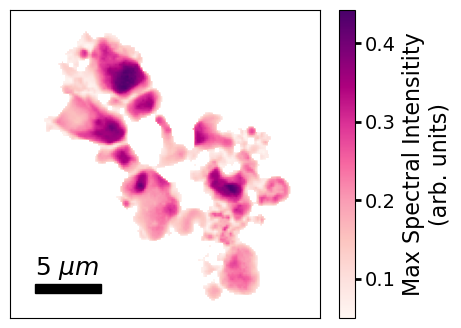

In [6]:
data = Fe_xanes
width = data.shape[1]
height = data.shape[2]

fig, ax = plt.subplots(figsize=(5, 4))

cmap = plt.cm.RdPu
img = ax.imshow(np.max(get_filtered_img(data), axis=0), extent=[0, 1, 0, 1],
                aspect='auto', cmap=cmap)
rect = mpatches.Rectangle((0.08, 0.08), (5000 / 150) * 1 / width, 5 * 1 / height, color='k')
ax.add_patch(rect)
ax.text(0.08, .14, '5 $\mu m$', fontsize=18, transform=ax.transData) # 1 pixel = 150 nm

remove_ticks(ax)

cbar = plt.colorbar(img, ax=ax)
cbar.ax.tick_params(width=2, length=4, labelsize=14)
cbar.ax.set_ylabel('Max Spectral Intensitity\n(arb. units)', fontsize=16)
plt.savefig('Figures/two-dim_heatmap.png', dpi=600,
            transparent=True, bbox_inches='tight')

In [7]:
'''
change this line to 
    %matplotlib notebook
to use the interactive feature in the plot below
''' 
%matplotlib inline

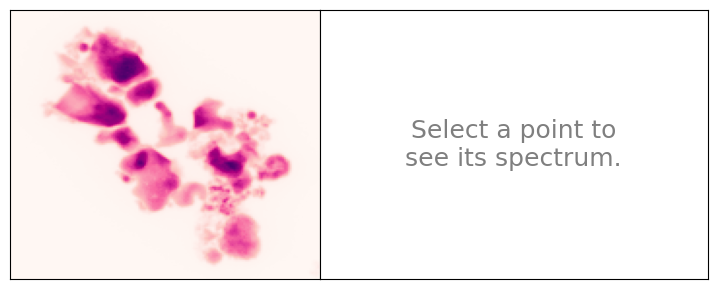

In [8]:
data = Fe_xanes

fig = plt.figure(figsize=(9, 3.5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
img = ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto',
                cmap=plt.cm.RdPu)

ax = fig.add_subplot(spec[1])
ax.text(0.5, 0.5, "Select a point to\nsee its spectrum.", fontsize=18, ha='center', va='center',
        c=plt.cm.tab10(7))

for ax in fig.get_axes():
    remove_ticks(ax)

add_point_label(img, data, ax)

# Step 1. Filter out background, i.e., space with no sample

In [6]:
data = Fe_xanes
energy = Fe_energy

fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

# Step 2. Normalize references, experimental spectra, XRF

In [7]:
normalized_spectra, normalized_spectra_dict = normalize_spectra(energy,
                                                                filtered_spectra,
                                                                filtered_spectra_dict,
                                                                whiteline_range=-1,
                                                                pre_edge_offset=10,
                                                                post_edge_offset=-28)
# Renormalize references
Refs, Refs_dict = normalize_spectra(energy, Refs, Refs_dict, pre_edge_offset=10,
                                    post_edge_offset=-28, whiteline_range=-1)
Refs = np.array(Refs)

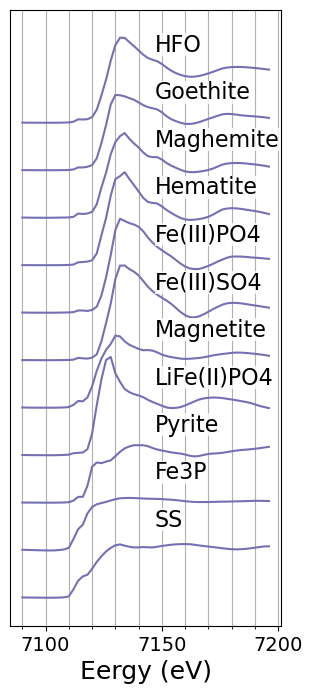

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 8))
for i, r in enumerate(Refs):
    ax.plot(energy, r + i * 0.9, c=plt.cm.Dark2(2))
    label = data_columns[i]
    if i == 0:
        label = 'SS'
    t = ax.text(7147, 1.35 + i * 0.9, label, fontsize=16)
    t.set_bbox(dict(facecolor='w', alpha=.8, edgecolor='none', pad=0.))
ax.set_yticks([])
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.grid(axis='x', which='both')
ax.tick_params(labelsize=14)
ax.set_xlabel('Eergy (eV)', fontsize=18)

plt.savefig('Figures/Refs.png', dpi=600, bbox_inches='tight')

In [8]:
xrf = []
global_mask = mask[0, :, :]

for i in [0, 2, 3]:
    ele = elements[i]
    norm_xrf = xrfs[elements[i]]
    norm_xrf = norm_xrf - np.min(norm_xrf)
    norm_xrf = norm_xrf / np.max(norm_xrf)
    masked_img = np.ma.masked_array(norm_xrf, mask=global_mask)
    norm_xrf = norm_xrf / np.max(masked_img)
    bool_arr = np.array(global_mask, dtype=bool).reshape(-1)
    filtered_img = norm_xrf.reshape(-1)
    xrf_data = np.array([d for i, d in enumerate(filtered_img) if not bool_arr[i]])
    xrf.append(xrf_data)

xrf = np.array(xrf).T
print(xrf.shape)

(6720, 3)


# Step 3. Manifold Projection Image Segmentation

0 -> 12
1 -> 13
4 -> 6
2 -> 19
Couldn't cluster 0 points
0 -> 12
3 -> 13
2 -> 6
1 -> 19


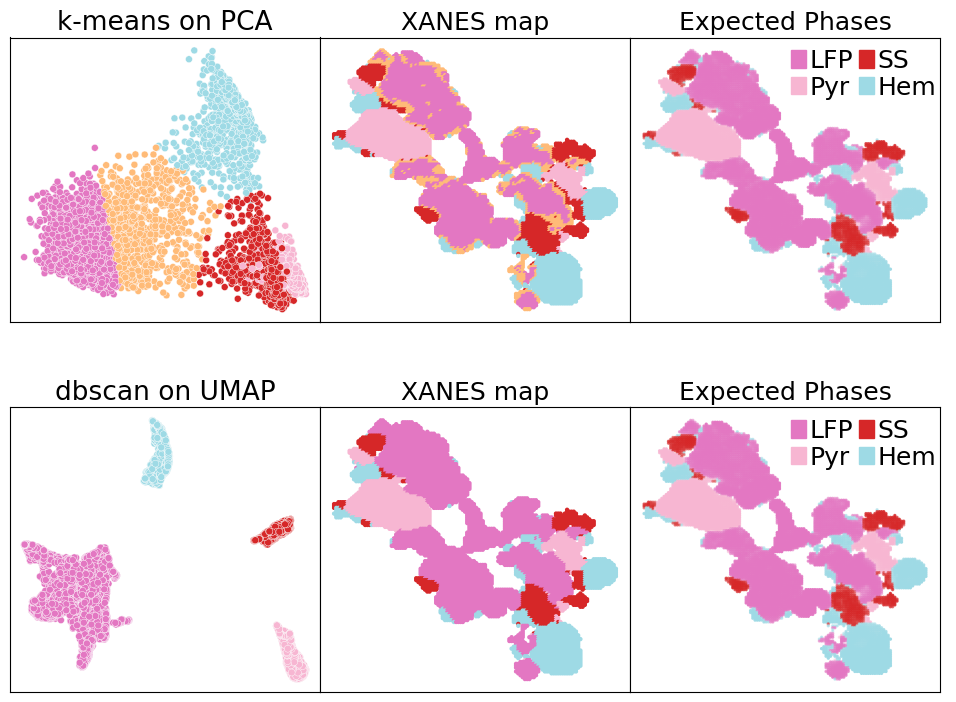

In [14]:
fig, axes = plt.subplots(figsize=(12, 8.5), ncols=3, nrows=2)
plt.subplots_adjust(wspace=0., hspace=0.3)

two_dimensional_clustering((fig, axes[0, :]), normalized_spectra, normalized_spectra_dict, 
                           Refs, method='PCA', clustering='k-means',
                           translation=2, n_clusters=5, data_description='full_spectra')

two_dimensional_clustering((fig, axes[1, :]), normalized_spectra, normalized_spectra_dict, 
                           Refs, method='UMAP', clustering='dbscan',
                           translation=2, data_description='full_spectra')

### Compare how noise impacts results

In [134]:
scales = np.array([0, 0.01, 0.02, 0.05])
true_contrib_indices = [0, 2, 3, 7]
basis = Refs[true_contrib_indices]

targets = normalized_spectra
short_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])

true_coeffs = np.zeros((len(targets), len(Refs)))
for j, idx in enumerate(true_contrib_indices):
    true_coeffs[:, idx] = short_coeffs[:, j]

Errors = [[], []]
Reduced_spaces = []
Clusterizers = []
Expected_coeffs = []
Pred_coeffs = []

for scale in scales:
    print(scale)
    
    data = np.array([s + np.random.normal(scale=scale * (s - np.min(s)), size=len(s)) for s in targets])
    expected_coeffs = get_coeffs_from_spectra(data, Refs)
    
    reduced_space = get_reduced_space(data, normalized_spectra_dict, method='UMAP', 
                                      n_neighbors=20)
    
    clusterizer = DBSCAN(eps=1, min_samples=1).fit(reduced_space)
    cluster_avgs = get_cluster_avgs(clusterizer, data)
    
    cluster_pred_coeffs = get_coeffs_from_spectra(cluster_avgs, Refs)
    pred_coeffs = np.array([cluster_pred_coeffs[clusterizer.labels_[i]] 
                            for i, s in enumerate(data)])
    
    pred_error = np.array([mean_squared_error(pred_coeffs[i], true_coeffs[i]) 
                           for i in range(len(true_coeffs))])
    expected_error = np.array([mean_squared_error(expected_coeffs[i], true_coeffs[i]) 
                               for i in range(len(true_coeffs))])
    
    Reduced_spaces.append(reduced_space)
    Clusterizers.append(clusterizer)
    Errors[0].append(pred_error)
    Errors[1].append(expected_error)
    Expected_coeffs.append(expected_coeffs)
    Pred_coeffs.append(pred_coeffs)
Errors = np.array(Errors)
Expected_coeffs = np.array(Expected_coeffs)
Pred_coeffs = np.array(Pred_coeffs)

0.0
0.01
0.02
0.05


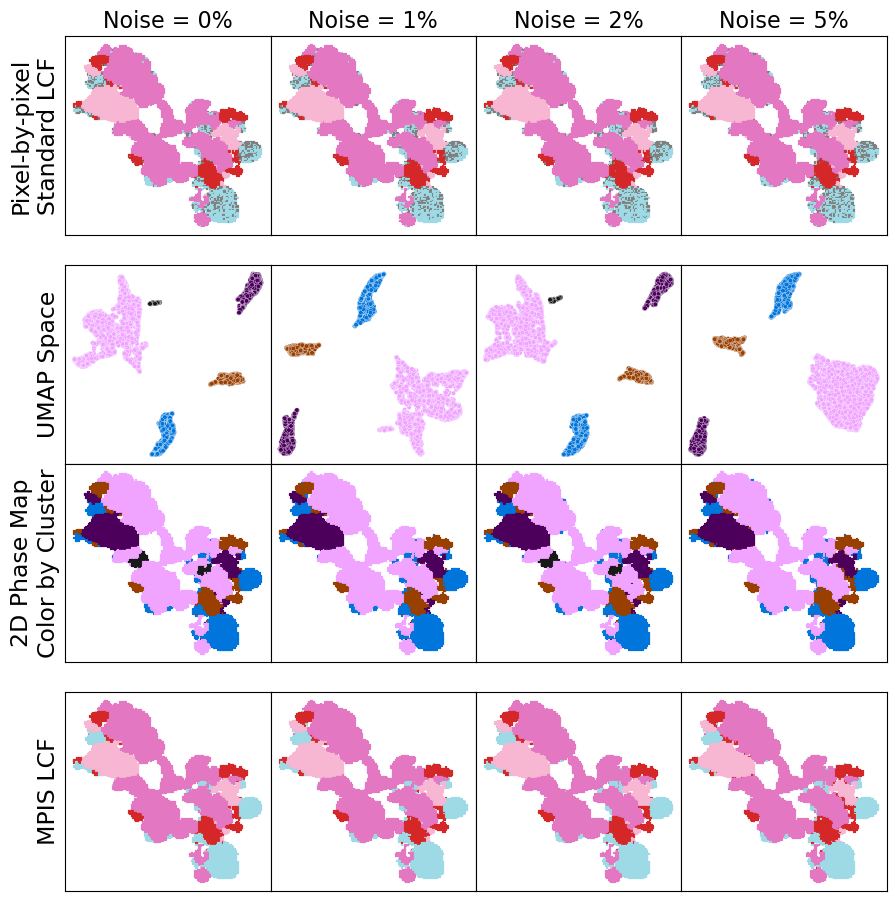

In [135]:
pts = np.array(list(normalized_spectra_dict.keys()))
color_labels = [6, 14, 13, 12, 14, 14, 14, 19, 14, 14, 14]

ncols = len(scales)
nrows = 4
blank_space = 0.15
height_ratios = [1, blank_space, 1, 1, blank_space, 1]
blank_rows = [1, 4]

fig = plt.figure(figsize=(2.65 * ncols, 2.7 * nrows + blank_space * 2))
spec = fig.add_gridspec(ncols=ncols, nrows=nrows + 2, height_ratios=height_ratios)
axes = np.array([[fig.add_subplot(spec[i, j]) for j in range(ncols)] for i in range(nrows + 2)])
plt.subplots_adjust(wspace=0., hspace=0.)

for i in range(ncols):
    exp_conc = np.argsort(Expected_coeffs[i], axis=1)
    pred_conc = np.argsort(Pred_coeffs[i], axis=1)
    
    axes[0, i].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                       color=[plt.cm.tab20(color_labels[c]) for c in exp_conc[:, -1]], lw=0.1)
    axes[2, i].scatter(Reduced_spaces[i][:, 0], Reduced_spaces[i][:, 1], ec='w', s=10,
                       color=[discrete_cmap[c] for c in Clusterizers[i].labels_], lw=0.2)
    axes[3, i].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                       color=[discrete_cmap[c] for c in Clusterizers[i].labels_], lw=0.1)
    axes[5, i].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                       color=[plt.cm.tab20(color_labels[c]) for c in pred_conc[:, -1]], lw=0.1)
    
    axes[0, i].set_title(f'Noise = {int(scales[i] * 100)}%', fontsize=16)
    
    for j, ax in enumerate(axes[:, i]):
        if j in blank_rows:
            ax.axis('off')
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    
    if i == 0:
        axes[0, i].set_ylabel('Pixel-by-pixel\nStandard LCF', fontsize=17)
        axes[2, i].set_ylabel('UMAP Space', fontsize=17)
        axes[3, i].set_ylabel('2D Phase Map\nColor by Cluster', fontsize=17)
        axes[5, i].set_ylabel('MPIS LCF', fontsize=17)
        
        
plt.savefig('Figures/MPIS_on_noise.png', dpi=600, bbox_inches='tight')

Text(0, 0.5, 'Black =\nincorrect phase')

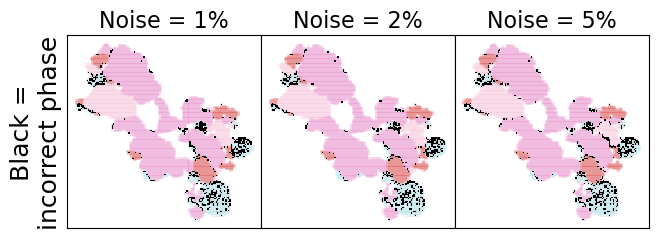

In [171]:
exp_phases = np.argsort(Expected_coeffs[0], axis=1)[:, -1]

fig, axes = plt.subplots(figsize=(7.5, 2.5), ncols=3)
plt.subplots_adjust(wspace=0)

for i, ax in enumerate(axes):
    ax.scatter(pts[:, 1], -pts[:, 0], s=4, marker='s', alpha=0.15,
               color=[plt.cm.tab20(color_labels[c]) for c in exp_phases], lw=0.)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Noise = {int(scales[i + 1] * 100)}%', fontsize=16)

for j, pred_coeffs in enumerate(Pred_coeffs[1:]):
    pred_phases = np.argsort(pred_coeffs, axis=1)[:, -1]
    errors = ['k' if exp_phases[i] != pred_phases[i] else (1, 1, 1, 0.) for i in range(len(pred_phases))]
    axes[j].scatter(pts[:, 1], -pts[:, 0], s=1, marker='s', color=errors, lw=0.)
    
axes[0].set_ylabel('Black =\nincorrect phase', fontsize=18)

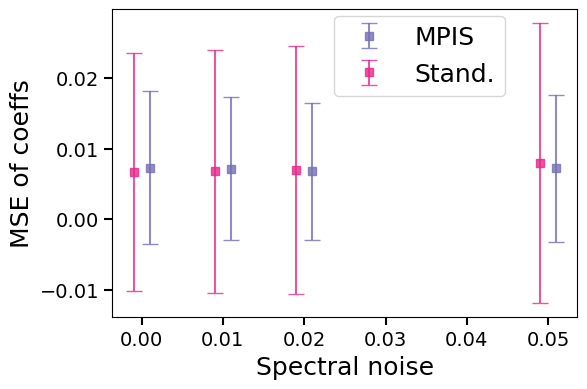

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))
labels = ['MPIS', 'Stand.']
for i, errors in enumerate(Errors): # + 0.005 * (-1)**(i%2)
    ax.errorbar(scales + 0.001 * (-1)**(i%2), np.average(errors, axis=1),
                yerr=np.std(errors, axis=1), alpha=0.8,
                marker='s', c=plt.cm.Dark2(2 + i), capsize=6,
                linestyle='none', label=labels[i])
ax.tick_params(length=6, labelsize=14, width=1.5)
ax.set_ylabel('MSE of coeffs', fontsize=18)
ax.set_xlabel('Spectral noise', fontsize=18)
ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(0.45, 1.02))

plt.show()

### See how multimodal information helps with high noise spectra

In [14]:
scale = 0.1
true_contrib_indices = [0, 2, 3, 7]
basis = Refs[true_contrib_indices]

targets = normalized_spectra
short_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])

true_coeffs = np.zeros((len(targets), len(Refs)))
for j, idx in enumerate(true_contrib_indices):
    true_coeffs[:, idx] = short_coeffs[:, j]

encoding_strengths = [[0, 0], [8, 0.5]]

Scores = [[], []]
Reduced_spaces = []
Clusterizers = []
Expected_coeffs = []
Pred_coeffs = []

for encoding_strength in encoding_strengths:
    xrf_strength, spatial_strength = encoding_strength
    
    data = np.array([s + np.random.normal(scale=scale * (s - np.min(s)), size=len(s)) for s in targets])
    expected_coeffs = get_coeffs_from_spectra(data, Refs)

    reduced_space = get_reduced_space(data, normalized_spectra_dict, method='UMAP', 
                                      n_neighbors=20, xrf=xrf, xrf_strength=xrf_strength,
                                      spatial_strength=spatial_strength)

    clusterizer = DBSCAN(eps=1, min_samples=1).fit(reduced_space)
    cluster_avgs = get_cluster_avgs(clusterizer, data)

    cluster_pred_coeffs = get_coeffs_from_spectra(cluster_avgs, Refs)
    pred_coeffs = np.array([cluster_pred_coeffs[clusterizer.labels_[i]] 
                            for i, s in enumerate(data)])

    pred_score = np.array([r2_score(pred_coeffs[i], true_coeffs[i]) 
                           for i in range(len(true_coeffs))])
    expected_score = np.array([r2_score(expected_coeffs[i], true_coeffs[i]) 
                               for i in range(len(true_coeffs))])
    
    Reduced_spaces.append(reduced_space)
    Clusterizers.append(clusterizer)
    Scores[0].append(pred_score)
    Scores[1].append(expected_score)
    Expected_coeffs.append(expected_coeffs)
    Pred_coeffs.append(pred_coeffs)
Expected_coeffs = np.array(Expected_coeffs)
Pred_coeffs = np.array(Pred_coeffs)
Scores = np.average(np.array(Scores), axis=2)

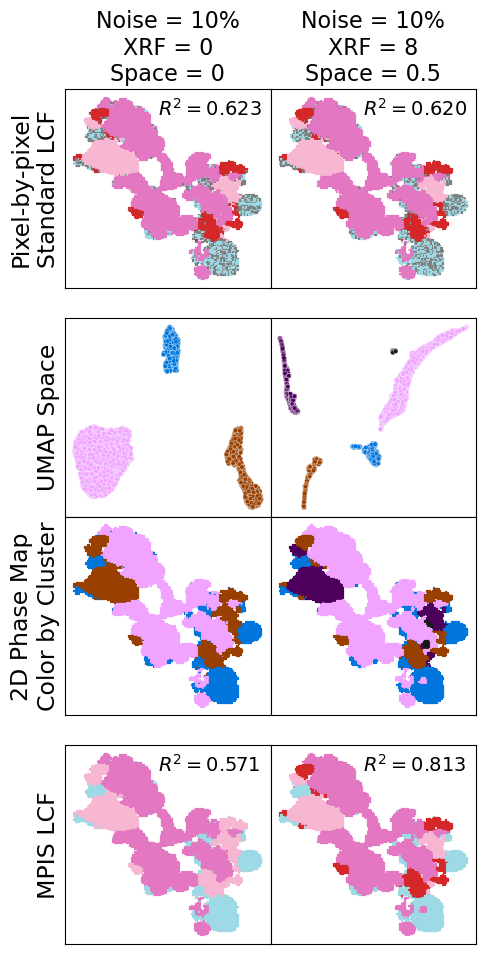

In [15]:
pts = np.array(list(normalized_spectra_dict.keys()))
color_labels = [6, 14, 13, 12, 14, 14, 14, 19, 14, 14, 14]

ncols = len(encoding_strengths)
nrows = 4
blank_space = 0.15
height_ratios = [1, blank_space, 1, 1, blank_space, 1]
blank_rows = [1, 4]

fig = plt.figure(figsize=(2.65 * ncols, 2.7 * nrows + blank_space * 2))
spec = fig.add_gridspec(ncols=ncols, nrows=nrows + 2, height_ratios=height_ratios)
axes = np.array([[fig.add_subplot(spec[i, j]) for j in range(ncols)] for i in range(nrows + 2)])
plt.subplots_adjust(wspace=0., hspace=0.)

for i in range(ncols):
    exp_conc = np.argsort(Expected_coeffs[i], axis=1)
    pred_conc = np.argsort(Pred_coeffs[i], axis=1)
    
    axes[0, i].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                       color=[plt.cm.tab20(color_labels[c]) for c in exp_conc[:, -1]], lw=0.1)
    axes[2, i].scatter(Reduced_spaces[i][:, 0], Reduced_spaces[i][:, 1], ec='w', s=10,
                       color=[discrete_cmap[c] for c in Clusterizers[i].labels_], lw=0.2)
    axes[3, i].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                       color=[discrete_cmap[c] for c in Clusterizers[i].labels_], lw=0.1)
    axes[5, i].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                       color=[plt.cm.tab20(color_labels[c]) for c in pred_conc[:, -1]], lw=0.1)
    
    axes[0, i].set_title(f'Noise = {int(scale * 100)}%\nXRF = {encoding_strengths[i][0]}\n' + 
                         f'Space = {encoding_strengths[i][1]}', fontsize=16)
    
    axes[5, i].text(0.45, 0.87, f'$R^2=${Scores[0, i]:.3f}', fontsize=14, transform=axes[5, i].transAxes)
    axes[0, i].text(0.45, 0.87, f'$R^2=${Scores[1, i]:.3f}', fontsize=14, transform=axes[0, i].transAxes)
    
    for j, ax in enumerate(axes[:, i]):
        if j in blank_rows:
            ax.axis('off')
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    
    if i == 0:
        axes[0, i].set_ylabel('Pixel-by-pixel\nStandard LCF', fontsize=17)
        axes[2, i].set_ylabel('UMAP Space', fontsize=17)
        axes[3, i].set_ylabel('2D Phase Map\nColor by Cluster', fontsize=17)
        axes[5, i].set_ylabel('MPIS LCF', fontsize=17)

### Visualize phase boundaries

In [16]:
true_contrib_indices = [0, 2, 3, 7]
basis = Refs[true_contrib_indices]

targets = normalized_spectra
short_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])

true_coeffs = np.zeros((len(targets), len(Refs)))
for j, idx in enumerate(true_contrib_indices):
    true_coeffs[:, idx] = short_coeffs[:, j]

expected_coeffs = get_coeffs_from_spectra(targets, Refs)

# MPIS
reduced_space = get_reduced_space(targets, normalized_spectra_dict, method='UMAP', 
                                  n_neighbors=20)
    
clusterizer = DBSCAN(eps=1, min_samples=1).fit(reduced_space)
cluster_avgs = get_cluster_avgs(clusterizer, targets)
    
cluster_pred_coeffs = get_coeffs_from_spectra(cluster_avgs, Refs)
pred_coeffs = np.array([cluster_pred_coeffs[clusterizer.labels_[i]] for i, s in enumerate(data)])

# get majority phase
exp_phases = np.argsort(expected_coeffs, axis=1)
pred_phases = np.argsort(pred_coeffs, axis=1)

In [111]:
majority_phases = pred_phases[:, -1]
color_dict = {tuple(pts[i, :]): majority_phases[i] for i in range(len(majority_phases))}

boundary_dict = {}
point_list = list(color_dict.keys())
black = (0.3, 0.3, 0.3, 1)
for pt in point_list:
    if (pt[0] - 1, pt[1]) not in point_list or color_dict[(pt[0] - 1, pt[1])] != color_dict[pt]:
        c = black
    elif (pt[0] + 1, pt[1]) not in point_list or color_dict[(pt[0] + 1, pt[1])] != color_dict[pt]:
        c = black
    elif (pt[0], pt[1] - 1) not in point_list or color_dict[(pt[0], pt[1] - 1)] != color_dict[pt]:
        c = black
    elif (pt[0], pt[1] + 1) not in point_list or color_dict[(pt[0], pt[1] + 1)] != color_dict[pt]:
        c = black
    else:
        c = (0, 0, 0, 0)
    boundary_dict[pt] = c

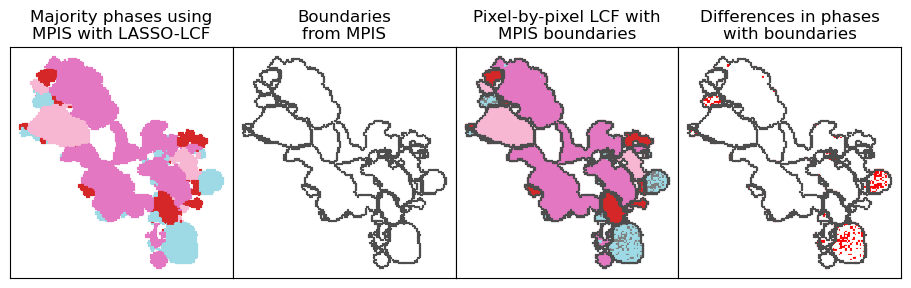

In [133]:
pts = np.array(list(normalized_spectra_dict.keys()))
color_labels = [6, 14, 13, 12, 14, 14, 14, 19, 14, 14, 14]

fig, axes = plt.subplots(figsize=(11.5, 3), ncols=4)
plt.subplots_adjust(wspace=0.)

axes[0].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                color=[plt.cm.tab20(color_labels[c]) for c in pred_phases[:, -1]], lw=0.1)

axes[2].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                color=[plt.cm.tab20(color_labels[c]) for c in exp_phases[:, -1]], lw=0.1)

errors = ['r' if exp_phases[i, -1] != pred_phases[i, -1] else 'w'
              for i in range(len(pred_phases))]
axes[3].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s', color=errors, lw=0.1)

for ax in axes[1:]:
    ax.scatter(pts[:, 1], -pts[:, 0], s=3, marker='s', color=list(boundary_dict.values()), lw=0.1)
    
titles = ['Majority phases using\nMPIS with LASSO-LCF', 'Boundaries\nfrom MPIS', 
          'Pixel-by-pixel LCF with\nMPIS boundaries', 'Differences in phases\nwith boundaries']
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i])

In [43]:
# to visualize UMAP connectivity graph:
# import umap.plot
# mapper = reducer.fit(pca_components)
# umap.plot.connectivity(mapper, edge_bundling='hammer')

### Grid search different multimodal weighting parameters

In [172]:
true_contrib_indices = [0, 2, 3, 7]
basis = Refs[true_contrib_indices]
targets = normalized_spectra

shortlist_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])

expected_coeffs = np.zeros((len(targets), len(Refs)))
for j, idx in enumerate(true_contrib_indices):
    expected_coeffs[:, idx] = shortlist_coeffs[:, j]

standard_coeffs = np.array([list(nnls(Refs.T, target)[0]) for target in targets])

standard_r2_scores = np.array([r2_score(standard_coeffs[i], expected_coeffs[i]) 
                               for i in range(len(expected_coeffs))])

lasso_coeffs = get_coeffs_from_spectra(targets, Refs)
lasso_r2_scores = np.array([r2_score(lasso_coeffs[i], expected_coeffs[i]) 
                            for i in range(len(expected_coeffs))])

In [173]:
xrf_strengths = [0, 5, 10]
spatial_strengths = [0, 0.5, 1.0]

Reduced_spaces = [[] for i in range(len(xrf_strengths))]
Clusterizers = [[] for i in range(len(xrf_strengths))]
Cluster_avgs = [[] for i in range(len(xrf_strengths))]
Colors = [[] for i in range(len(xrf_strengths))]

cmap = plt.cm.tab20

for i in range(len(xrf_strengths)):
    for j in range(len(spatial_strengths)):
        xrf_strength = xrf_strengths[i]
        spatial_strength = spatial_strengths[j]
        print(f'XRF x {xrf_strength} \tSpace x {spatial_strength}', end='   \t')
        
        reduced_space = get_reduced_space(normalized_spectra, normalized_spectra_dict, 
                                          xrf_strength=xrf_strength, xrf=xrf, n_neighbors=20,
                                          spatial_strength=spatial_strength,
                                          method='UMAP')
        clusterizer, _, color_labels, _, _ = apply_clustering(reduced_space, 'dbscan', normalized_spectra_dict)
        colors = [cmap(c) for c in color_labels]
        cluster_avgs = get_cluster_avgs(clusterizer, normalized_spectra)
        Reduced_spaces[i].append(reduced_space)
        Clusterizers[i].append(clusterizer)
        Cluster_avgs[i].append(cluster_avgs)
        Colors[i].append(colors)

XRF x 0 	Space x 0   	Couldn't cluster 0 points
XRF x 0 	Space x 0.5   	Couldn't cluster 0 points
XRF x 0 	Space x 1.0   	Couldn't cluster 0 points
XRF x 5 	Space x 0   	Couldn't cluster 0 points
XRF x 5 	Space x 0.5   	Couldn't cluster 0 points
XRF x 5 	Space x 1.0   	Couldn't cluster 0 points
XRF x 10 	Space x 0   	Couldn't cluster 0 points
XRF x 10 	Space x 0.5   	Couldn't cluster 0 points
XRF x 10 	Space x 1.0   	Couldn't cluster 0 points


In [174]:
for i in range(len(xrf_strengths)):
    for j in range(len(spatial_strengths)):
        clusterizer = Clusterizers[i][j]
        print(len(np.unique(clusterizer.labels_)))

4
10
16
6
8
10
5
5
9


XRF x 0 	Space x 0
XRF x 0 	Space x 0.5
XRF x 0 	Space x 1.0
XRF x 5 	Space x 0
XRF x 5 	Space x 0.5
XRF x 5 	Space x 1.0
XRF x 10 	Space x 0
XRF x 10 	Space x 0.5
XRF x 10 	Space x 1.0


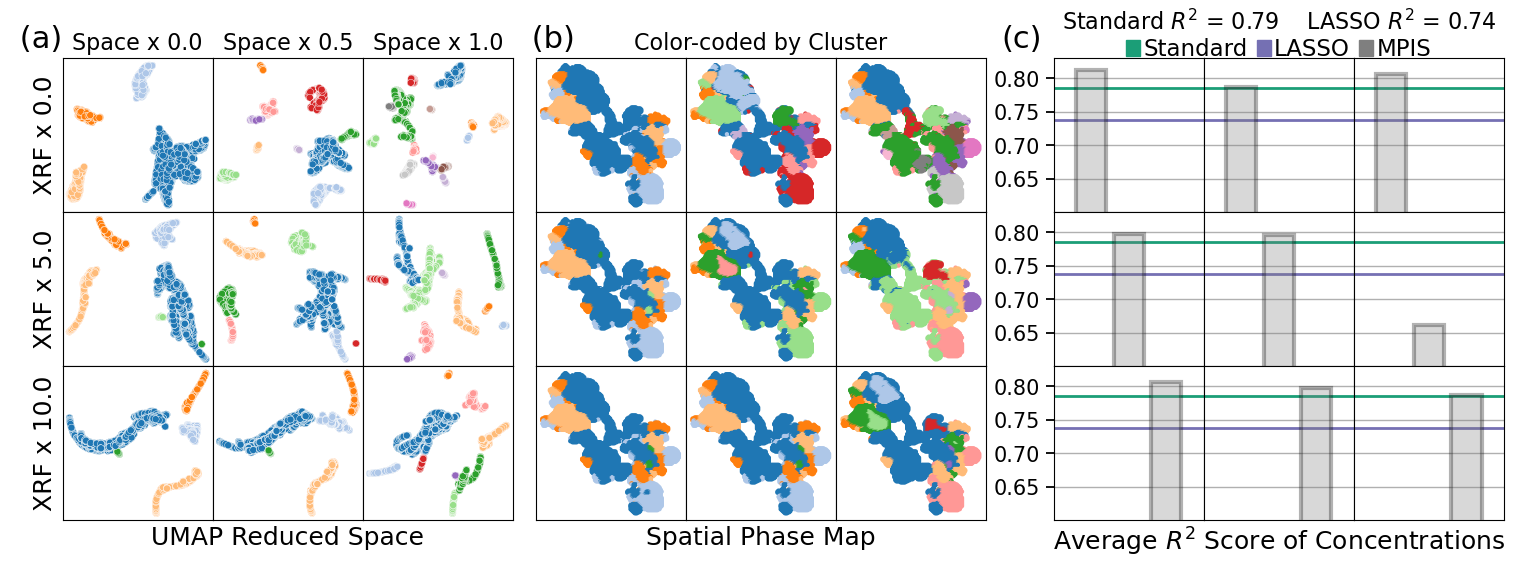

In [193]:
nrows = len(xrf_strengths)
ncols = len(spatial_strengths) * 3 + 2
blank_cols = [3, 7]
blank_spaces = [0.15, 0.45]

fig = plt.figure(figsize=(2 * (ncols - 2) + np.sum(blank_spaces), 2 * nrows))
width_ratios = np.ones(ncols)
for i, idx in enumerate(blank_cols):
    width_ratios[idx] = blank_spaces[i]
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=width_ratios)
axes = [[fig.add_subplot(spec[i, j]) for j in range(ncols)] for i in range(nrows)]
plt.subplots_adjust(wspace=0., hspace=0.)

for i in range(len(xrf_strengths)):
    for j in range(len(spatial_strengths)):
        xrf_strength = xrf_strengths[i]
        spatial_strength = spatial_strengths[j]
        print(f'XRF x {xrf_strength} \tSpace x {spatial_strength}')
        
        reduced_space = Reduced_spaces[i][j]
        clusterizer = Clusterizers[i][j]
        cluster_avgs = Cluster_avgs[i][j]
        colors = Colors[i][j]
        
        for k, dj in enumerate([0, 4, 8]):
            if k == 0:
                axes[i][j + dj].scatter(reduced_space[:, 0], reduced_space[:, 1],
                                        marker='o', color=colors, s=25, ec='w', linewidth=0.3)
            elif k == 1:
                plot_color_code_map((fig, axes[i][j + dj]), normalized_spectra_dict, colors)
                if i == 0 and j == 1:
                    axes[i][j + dj].set_title(f'Color-coded by Cluster', fontsize=16)
            elif k == 2:
                cluster_pred_coeffs = get_coeffs_from_spectra(cluster_avgs, Refs)
                pred_coeffs = np.array([cluster_pred_coeffs[clusterizer.labels_[i]] 
                                        for i, s in enumerate(normalized_spectra)])
                pred_r2_scores = np.array([r2_score(pred_coeffs[i], expected_coeffs[i]) 
                                           for i in range(len(expected_coeffs))])
                scores = np.array([np.average(standard_r2_scores), np.average(lasso_r2_scores),
                                   np.average(pred_r2_scores)])
                bar_colors = [plt.cm.Dark2(0), plt.cm.Dark2(2), plt.cm.Dark2(1)]
                bar_colors = [plt.cm.Dark2(0), plt.cm.Dark2(2), plt.cm.tab10(7)]
                axes[i][j + dj].bar([0.25 * i], scores[2], width=0.2, zorder=5, color=bar_colors[2], 
                                    alpha=0.3, edgecolor='k', lw=3)
                axes[i][j + dj].set_xlim(-0.25, 0.75)
                axes[i][j + dj].set_ylim(0.6, 0.83)
                
                axes[i][j + dj].axhline(scores[0], linestyle='-', lw=2, c=bar_colors[0])
                axes[i][j + dj].axhline(scores[1], linestyle='-', lw=2, c=bar_colors[1])
                
#                 axes[i][j + dj].bar(np.arange(3), scores, width=0.75, zorder=5, color=bar_colors)
#                 mpl.rcParams['hatch.linewidth'] = 2.0
#                 axes[i][j + dj].bar([2], scores[2], width=0.75, zorder=6, ec='w', fill=False, alpha=0.5, hatch='/')

                if i == 0 and j == 1:
                    axes[i][j + dj].set_title(f'Standard $R^2$ = {scores[0]:.2f}    ' +
                                              f'LASSO $R^2$ = {scores[1]:.2f}', y=1.13, fontsize=16)
                    labels = ['Standard', 'LASSO', 'MPIS']
                    hatches = ['-', '-', '/']
                    patches = [mpatches.Patch(color=bar_colors[i], label=labels[i], hatch=hatches[i]) 
                               for i in range(len(labels))]
                    leg = axes[i][j + dj].legend(handles=patches, fontsize=16.5, ncol=3, framealpha=0, 
                                                 handlelength=.6, loc='lower center', bbox_to_anchor=(0.5, 0.85),
                                                 labelspacing=.2, handletextpad=0.15, columnspacing=0.4)

            axes[i][j + dj].set_xticks([])
            if k == 2:
                axes[i][j + dj].tick_params(length=6, width=1.3, labelsize=15, which='major')
                axes[i][j + dj].set_yticks([0.65, 0.7, 0.75, 0.8])
                axes[i][j + dj].grid(which='major', lw=1, zorder=1)
                if j != 0:
                    axes[i][j + dj].tick_params(length=0, width=0)
                    axes[i][j + dj].set_yticklabels([])
            else:
                axes[i][j + dj].set_yticks([])
        if j == 0:
            axes[i][j].set_ylabel(f'XRF x {xrf_strength:.1f}', fontsize=18, x=0.1)
        if i == 0:
            axes[i][j].set_title(f'Space x {spatial_strength:.1f}', fontsize=16)
    if i == 2:
        axes[i][1].set_xlabel(f'UMAP Reduced Space', fontsize=18)
        axes[i][5].set_xlabel(f'Spatial Phase Map', fontsize=18)
        axes[i][9].set_xlabel(f'Average $R^2$ Score of Concentrations', fontsize=18)
            
    for blank_col in blank_cols:
        axes[i][blank_col].axis('off')
        
labels = [' (a)', '     (b)', '(c)']
for i, ax in enumerate([axes[0][0], axes[0][4], axes[0][8]]):
    ax.text(-0.35, 1.03, labels[i], fontsize=22, ha='left', va='bottom', transform=ax.transAxes)

plt.savefig('Figures/XRF_vs_spatial_encoding.png', dpi=600, bbox_inches='tight')

### Details of MPIS pipeline

It takes 6 PCs to explain
97% variance.
0 -> 12
3 -> 13
2 -> 6
1 -> 19


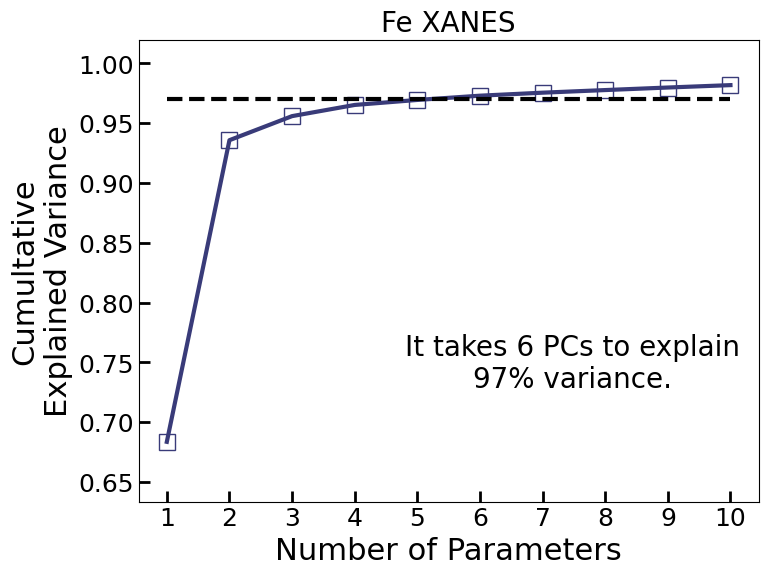

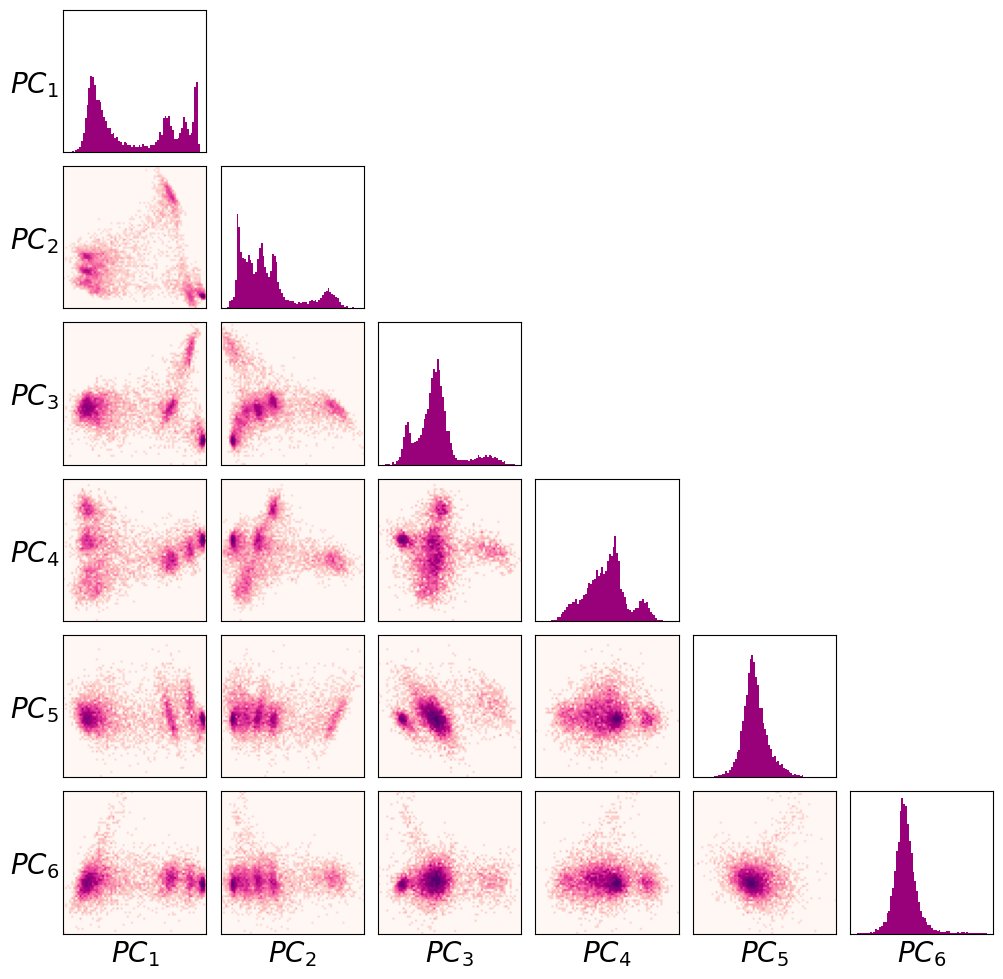

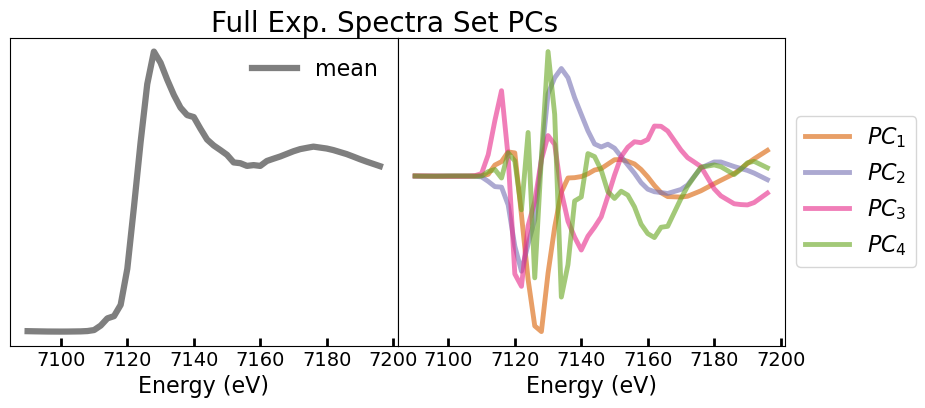

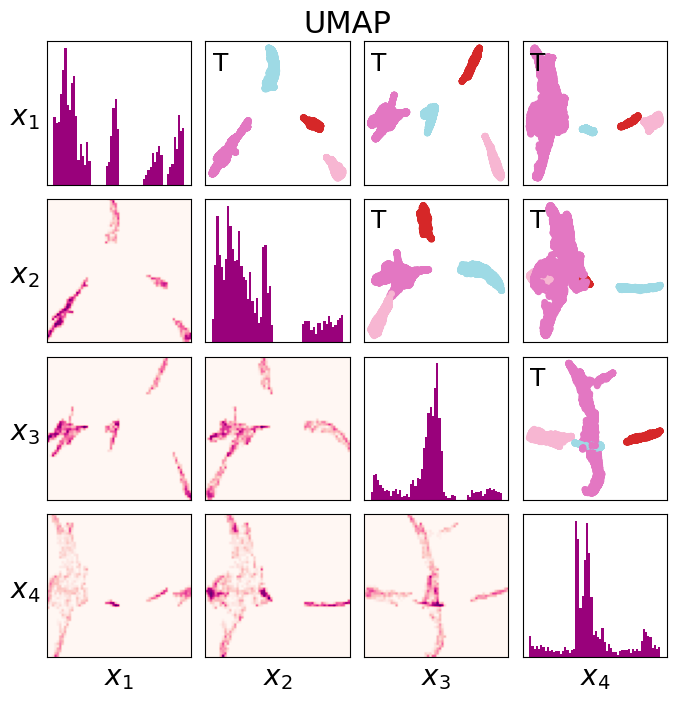

In [48]:
# PCA
n_components = make_scree_plot(normalized_spectra, n=10, c=0, threshold=0.97, show_first_PC=False)
plt.title('Fe XANES', fontsize=20)
plt.savefig('Figures/full_spectra_scree.png', dpi=600, bbox_inches='tight')

pca, pca_components = make_PCA_triangle_plot(normalized_spectra, n_components, bins=70,
                                             cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8))
plt.savefig('Figures/full_spectra_PCA_traingle_plot.png', dpi=600, bbox_inches='tight')

show_PCs(energy, pca, n=4)
plt.suptitle('Full Exp. Spectra Set PCs', fontsize=20, y=0.95)
plt.savefig('Figures/full_spectra_first_PCs.png', dpi=600, bbox_inches='tight')

# UMAP & dbscan
color_labels, codemap, dbscan_clustering = make_UMAP_plot(pca_components, normalized_spectra_dict, eps=1.0,
                                                          n_neighbors=30, min_dist=0, dimension=4, bins=60,
                                                          cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8),
                                                          translation=2)
plt.savefig('Figures/full_spectra_UMAP.png', dpi=600, bbox_inches='tight')

if len(np.unique(dbscan_clustering.labels_)) != len(np.unique(color_labels)):
    print('Number of unique colors does not equal number of clusters. Check color map.')

# Part II. Recursive Feature Elimination

## Step 1. Slice energies

In [39]:
normalized_spectra, normalized_spectra_dict = normalize_spectra(energy,
                                                                filtered_spectra,
                                                                filtered_spectra_dict,
                                                                whiteline_range=-1,
                                                                pre_edge_offset=10,
                                                                post_edge_offset=-28)

In [40]:
indices = [0, 10, 13, 14, 15, 16, 18, 19, 20, 21, 23, 26, 27, 36, 38, 53]
energy_subset = np.array(energy[indices])
prenormalized_subset = np.array(normalized_spectra)[:, indices]
data_subset = np.array(filtered_spectra)[:, indices]

post_edge_energy_threshold = 7150
whiteline_threshold = 7138
post = np.sum(energy[indices] > post_edge_energy_threshold)
whiteline_range = np.sum(energy[indices] < whiteline_threshold)

postnormalized_subset, postnormalized_subset_dict = normalize_spectra(energy_subset,
                                                                              data_subset,
                                                                              filtered_spectra_dict,
                                                                              pre_edge_offset=2,
                                                                              post_edge_offset=-post,
                                                                              whiteline_range=whiteline_range,
                                                                              whiteline_mode='max')

Y_Refs, _ = normalize_spectra(energy_subset, Refs[:, indices], Refs_dict, whiteline_range=whiteline_range,
                              pre_edge_offset=2, post_edge_offset=-post, whiteline_mode='max')

In [41]:
plt.rcParams["font.family"] = "Times New Roman"

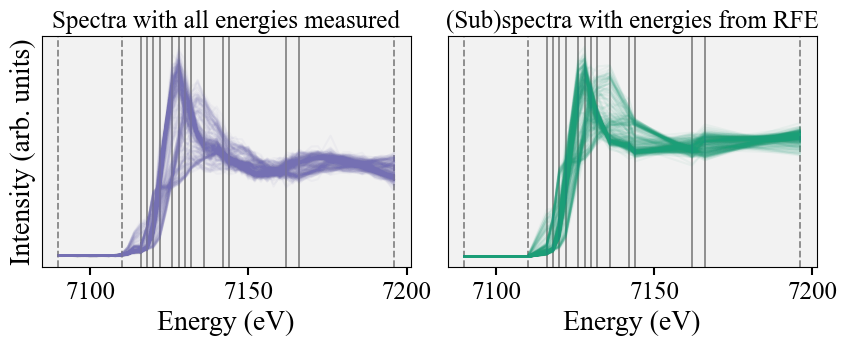

In [15]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=2)
plt.subplots_adjust(hspace=0.0, wspace=0.1)
labels = ['Spectra with all energies measured', '(Sub)spectra with energies from RFE']
colors = [plt.cm.Dark2(2), plt.cm.Dark2(0)]
        
rfe_indices = [13, 14, 15, 16, 18, 19, 20, 21, 23, 26, 27, 36, 38]
norm_indices = [0, 10, 53]
for j, ax in enumerate(axes):
    ax.set_facecolor(plt.cm.Pastel1(9))
    ax.set_yticks([])
    for i in rfe_indices:
        ax.axvline(energy[i], c='#404040', linewidth=1.3, zorder=0, alpha=0.6)
    for i in norm_indices:
        ax.axvline(energy[i], c='#404040', linestyle='--', linewidth=1.3, zorder=0, alpha=0.6)
    ax.tick_params(length=6, width=1.5, labelsize=18)
    ax.set_xlabel('Energy (eV)', fontsize=20)
    ax.set_title(labels[j], fontsize=18)
    
for i, s in enumerate(normalized_spectra):
    if i % 20 == 0:
        axes[0].plot(energy, s, '-', alpha=0.05, c=colors[0], lw=1.5, zorder=1e6)
        axes[1].plot(energy_subset, postnormalized_subset[i], '-', alpha=0.05, c=colors[1], lw=1.5, zorder=1e6)

axes[0].set_ylabel("Intensity (arb. units)", fontsize=20)
plt.savefig('Figures/full_vs_rfe_spectra.png', dpi=600, bbox_inches='tight')

In [16]:
true_contrib_indices = [0, 2, 3, 7]
basis = Refs[true_contrib_indices]

targets = normalized_spectra
short_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])

true_coeffs = np.zeros((len(targets), len(Refs)))
for j, idx in enumerate(true_contrib_indices):
    true_coeffs[:, idx] = short_coeffs[:, j]

standard_practice_coeffs = np.array([list(nnls(Refs.T, target)[0]) for target in targets])
expected_sub_coeffs = np.array([list(nnls(Y_Refs.T, target)[0]) for target in postnormalized_subset])

Reduced_spaces = []
Clusterizers = []
Expected_coeffs = []
Pred_coeffs = []

for targets, refs in [[normalized_spectra, Refs], [postnormalized_subset, Y_Refs]]:
    data = targets
    expected_coeffs = get_coeffs_from_spectra(data, refs)

    reduced_space = get_reduced_space(data, normalized_spectra_dict, method='UMAP', 
                                      n_neighbors=15, xrf=xrf, xrf_strength=0,
                                      spatial_strength=0)

    clusterizer = DBSCAN(eps=1, min_samples=1).fit(reduced_space)
    cluster_avgs = get_cluster_avgs(clusterizer, data)

    cluster_pred_coeffs = get_coeffs_from_spectra(cluster_avgs, refs)
    pred_coeffs = np.array([cluster_pred_coeffs[clusterizer.labels_[i]] 
                            for i, s in enumerate(data)])
    
    Reduced_spaces.append(reduced_space)
    Clusterizers.append(clusterizer)
    Expected_coeffs.append(expected_coeffs)
    Pred_coeffs.append(pred_coeffs)

In [30]:
from scipy.stats import wasserstein_distance

# b
b = sorted_stand_coeffs[:, -1]
# c 
c = sorted_exp_sub_coeffs[:, -1]
# d
d = np.argsort(Pred_coeffs[0], axis=1)[:, -1]
# e
e = np.argsort(Pred_coeffs[1], axis=1)[:, -1]

print(b.shape, c.shape, d.shape, e.shape)

bc = np.sum(b - c != 0) / len(b)
print(bc)

de = np.sum(d - e != 0) / len(b)
print(de)

(6720,) (6720,) (6720,) (6720,)
0.06473214285714286
0.03869047619047619


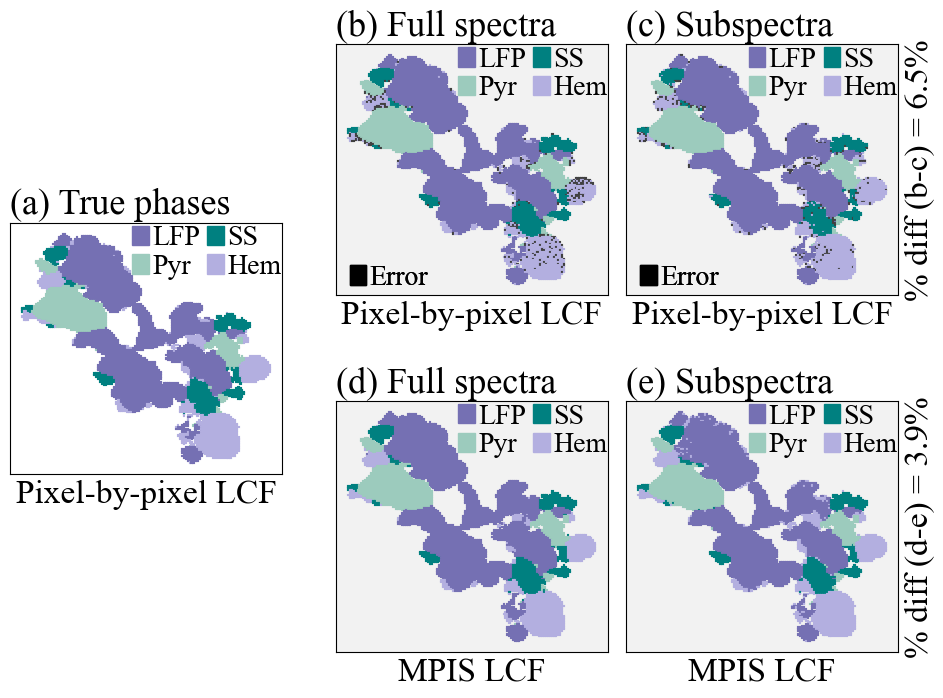

In [33]:
pts = np.array(list(normalized_spectra_dict.keys()))

gray = '#404040'
colors = ['#008080ff', gray, '#9ccbbdff', plt.cm.Dark2(2), 
          gray, gray, gray, '#b3afe0ff', gray, gray, gray]

labels = ['LFP', 'Pyr', 'SS', 'Hem']
short_color_labels = [3, 2, 0, 7]
patches = [mpatches.Patch(color=colors[short_color_labels[i]],
           label=labels[i]) for i in range(len(labels))]

ncols = 4
nrows = 4
blank_space = 0.06
width_ratios = [1, blank_space, 1, 1]

fig = plt.figure(figsize=(2.85 * ncols + blank_space, 3.95 * 2))
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=width_ratios)
axes = np.array([[fig.add_subplot(spec[i * 2:i * 2 + 2, j]) for j in range(ncols)] for i in range(2)])
plt.subplots_adjust(wspace=0.09, hspace=1.45)


titles = ['(d) Full spectra', '(e) Subspectra']
for i in range(2):
    ax = axes[1, 2 + i]
    pred_conc = np.argsort(Pred_coeffs[i], axis=1)
    ax.scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
               color=[colors[c] for c in pred_conc[:, -1]], lw=0.1)
    ax.set_title(f'{titles[i]}', fontsize=26, loc='left')
    ax.set_xlabel('MPIS LCF', fontsize=24)
    
    leg = ax.legend(handles=patches, fontsize=20, ncol=2, framealpha=0,
                    handlelength=.6, loc=1, bbox_to_anchor=(1.09, 1.09),
                    labelspacing=.1, handletextpad=0.12, columnspacing=0.25)
    if i == 1:
        ax.set_ylabel(f'% diff (d-e) = {de * 100:.1f}%', fontsize=24)
        ax.yaxis.set_label_position("right")


#ax = axes[0, 0]
ax = fig.add_subplot(spec[1:3, 0])
sorted_true_coeffs = np.argsort(true_coeffs, axis=1)
ax.scatter(pts[:, 1], -pts[:, 0], s=3, marker='s', 
                color=[colors[c] for c in sorted_true_coeffs[:, -1]], lw=0.1)
ax.set_title(f'(a) True phases', fontsize=26, loc='left')
ax.set_xlabel('Pixel-by-pixel LCF', fontsize=24)
leg = ax.legend(handles=patches, fontsize=20, ncol=2, framealpha=0, labelcolor='k',
                     handlelength=.6, loc=1, bbox_to_anchor=(1.09, 1.09),
                     labelspacing=.1, handletextpad=0.12, columnspacing=0.25)
ax.set_xticks([])
ax.set_yticks([])


ax = axes[0, 2]
sorted_stand_coeffs = np.argsort(standard_practice_coeffs, axis=1)
ax.scatter(pts[:, 1], -pts[:, 0], s=3, marker='s', 
           color=[colors[c] for c in sorted_stand_coeffs[:, -1]], lw=0.1)
ax.set_title(f'(b) Full spectra', fontsize=26, loc='left')
ax.set_xlabel('Pixel-by-pixel LCF', fontsize=24)
leg = ax.legend(handles=patches, fontsize=20, ncol=2, framealpha=0,
                handlelength=.6, loc=1, bbox_to_anchor=(1.09, 1.09),
                labelspacing=.1, handletextpad=0.12, columnspacing=0.25)

patches2 = [mpatches.Patch(color='k', label='Error')]
leg2 = ax.legend(handles=patches2, fontsize=20, ncol=2, framealpha=0,
                handlelength=.6, loc=3, bbox_to_anchor=(-.04, -.08),
                labelspacing=.1, handletextpad=0.12, columnspacing=0.25)

ax.add_artist(leg)
ax.add_artist(leg2)


ax = axes[0, 3]
sorted_exp_sub_coeffs = np.argsort(expected_sub_coeffs, axis=1)
ax.scatter(pts[:, 1], -pts[:, 0], s=3, marker='s', 
           color=[colors[c] for c in sorted_exp_sub_coeffs[:, -1]], lw=0.1)
ax.set_title(f'(c) Subspectra', fontsize=26, loc='left')
ax.set_xlabel('Pixel-by-pixel LCF', fontsize=24)
leg = ax.legend(handles=patches, fontsize=20, ncol=2, framealpha=0,
                handlelength=.6, loc=1, bbox_to_anchor=(1.09, 1.09),
                labelspacing=.1, handletextpad=0.12, columnspacing=0.25)

patches2 = [mpatches.Patch(color='k', label='Error')]
leg2 = ax.legend(handles=patches2, fontsize=20, ncol=2, framealpha=0,
                handlelength=.6, loc=3, bbox_to_anchor=(-.04, -.08),
                labelspacing=.1, handletextpad=0.12, columnspacing=0.25)

ax.add_artist(leg)
ax.add_artist(leg2)
ax.set_ylabel(f'% diff (b-c) = {bc * 100:.1f}%', fontsize=24)
ax.yaxis.set_label_position("right")

for axl in axes:
    for ax in axl:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_facecolor(plt.cm.Pastel1(9))

for i in range(2):
    for j in range(2):
        axes[i, j].axis('off')

plt.savefig('Figures/MPIS_LASSO_LCF_full_vs_sub_spectra.png', dpi=600, bbox_inches='tight')

In [189]:
scale = 0.1
true_contrib_indices = [0, 2, 3, 7]
basis = Refs[true_contrib_indices]

targets = normalized_spectra
short_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])

true_coeffs = np.zeros((len(targets), len(Refs)))
for j, idx in enumerate(true_contrib_indices):
    true_coeffs[:, idx] = short_coeffs[:, j]

encoding_strengths = [[2, 0.1], [2, 0.1], [0, 0]]

Errors = [[], []]
Reduced_spaces = []
Clusterizers = []
Expected_coeffs = []
Pred_coeffs = []

i = 0
for targets, refs in [[normalized_spectra, Refs], [postnormalized_subset, Y_Refs],
                      [postnormalized_subset, Y_Refs]]:

    xrf_strength, spatial_strength = encoding_strengths[i]

    data = np.array([s + np.random.normal(scale=scale * (s - np.min(s)), size=len(s)) for s in targets])
    expected_coeffs = get_coeffs_from_spectra(data, refs)

    reduced_space = get_reduced_space(data, normalized_spectra_dict, method='UMAP',
                                      n_neighbors=10, xrf=xrf, xrf_strength=xrf_strength,
                                      spatial_strength=spatial_strength)

    clusterizer = DBSCAN(eps=1, min_samples=1).fit(reduced_space)
    cluster_avgs = get_cluster_avgs(clusterizer, data)

    cluster_pred_coeffs = get_coeffs_from_spectra(cluster_avgs, refs)
    pred_coeffs = np.array([cluster_pred_coeffs[clusterizer.labels_[i]] 
                            for i, s in enumerate(data)])

    pred_error = np.array([mean_squared_error(pred_coeffs[i], true_coeffs[i]) 
                           for i in range(len(true_coeffs))])
    expected_error = np.array([mean_squared_error(expected_coeffs[i], true_coeffs[i]) 
                               for i in range(len(true_coeffs))])
    
    Reduced_spaces.append(reduced_space)
    Clusterizers.append(clusterizer)
    Errors[0].append(pred_error)
    Errors[1].append(expected_error)
    Expected_coeffs.append(expected_coeffs)
    Pred_coeffs.append(pred_coeffs)
    i += 1

Errors = np.array(Errors)
Expected_coeffs = np.array(Expected_coeffs)
Pred_coeffs = np.array(Pred_coeffs)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


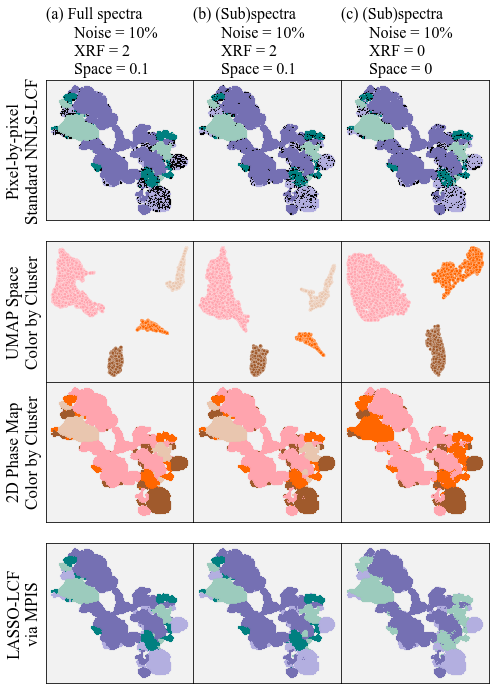

In [190]:
pts = np.array(list(normalized_spectra_dict.keys()))
gray = '#000000ff'
colors = ['#008080ff', gray, '#9ccbbdff', plt.cm.Dark2(2), 
          gray, gray, gray, '#b3afe0ff', gray, gray, gray]

extended_colors = ['#ffa4aeff', '#a05a2cff', '#ff6600ff', '#e9c6afff',
                   '#aa4400ff', '#ffccaaff', '#800000ff']

titles = ['Full spectra', '(Sub)spectra', '(Sub)spectra']
letters = ['a', 'b', 'c']

ncols = len(encoding_strengths)
nrows = 4
blank_space = 0.15
height_ratios = [1, blank_space, 1, 1, blank_space, 1]
blank_rows = [1, 4]

fig = plt.figure(figsize=(2.65 * ncols, 2.7 * nrows + blank_space * 2))
spec = fig.add_gridspec(ncols=ncols, nrows=nrows + 2, height_ratios=height_ratios)
axes = np.array([[fig.add_subplot(spec[i, j]) for j in range(ncols)] for i in range(nrows + 2)])
plt.subplots_adjust(wspace=0., hspace=0.)

for i in range(ncols):
    exp_conc = np.argsort(Expected_coeffs[i], axis=1)
    pred_conc = np.argsort(Pred_coeffs[i], axis=1)
    
    axes[0, i].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                       color=[colors[c] for c in exp_conc[:, -1]], lw=0.1)
    axes[2, i].scatter(Reduced_spaces[i][:, 0], Reduced_spaces[i][:, 1], ec='w', s=10,
                       color=[extended_colors[c] for c in Clusterizers[i].labels_], lw=0.2)
    axes[3, i].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                       color=[extended_colors[c] for c in Clusterizers[i].labels_], lw=0.1)
    axes[5, i].scatter(pts[:, 1], -pts[:, 0], s=3, marker='s',
                       color=[colors[c] for c in pred_conc[:, -1]], lw=0.1)
    
    axes[0, i].set_title(f'({letters[i]}) {titles[i]}\n' + 
                         f'       Noise = {int(scale * 100)}%\n' + 
                         f'       XRF = {encoding_strengths[i][0]}\n' + 
                         f'       Space = {encoding_strengths[i][1]}', 
                         loc='left', fontsize=16)
    
    for j, ax in enumerate(axes[:, i]):
        if j in blank_rows:
            ax.axis('off')
        else:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(plt.cm.Pastel1(9))
    
    if i == 0:
        axes[0, i].set_ylabel('Pixel-by-pixel\nStandard NNLS-LCF', fontsize=17)
        axes[2, i].set_ylabel('UMAP Space\nColor by Cluster', fontsize=17)
        axes[3, i].set_ylabel('2D Phase Map\nColor by Cluster', fontsize=17)
        axes[5, i].set_ylabel('LASSO-LCF\nvia MPIS', fontsize=17)
        
plt.savefig('Figures/sub_spectra_MPIS_with_noise.png', dpi=600, bbox_inches='tight')

It takes 6 PCs to explain
97% variance.
It takes 7 PCs to explain
99% variance.


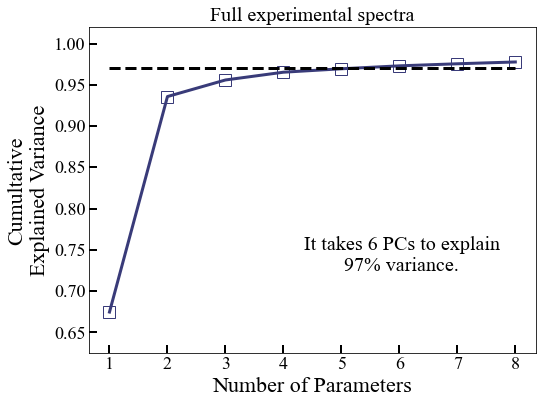

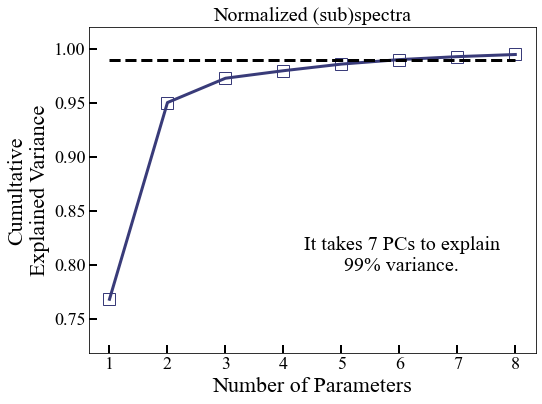

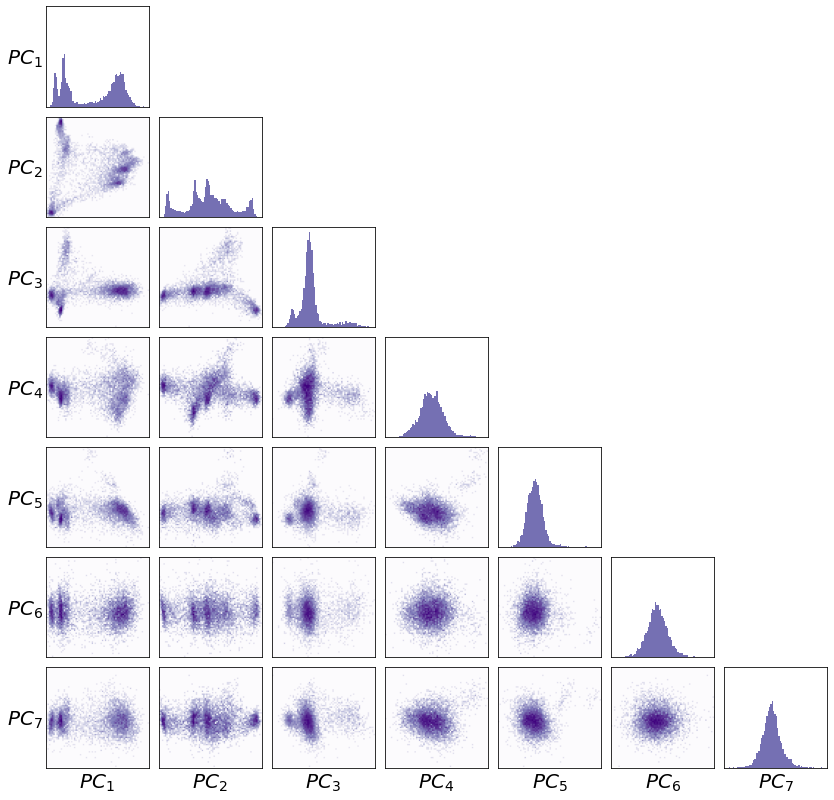

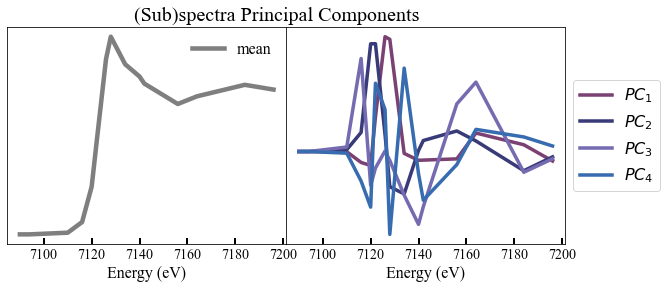

In [34]:
n_components = make_scree_plot(normalized_spectra, n=8, c=0, threshold=0.97, show_first_PC=False)
plt.title('Full experimental spectra', fontsize=20)

n_components_sub = make_scree_plot(postnormalized_subset, n=8, c=0, threshold=0.99, show_first_PC=False)
plt.title('Normalized (sub)spectra', fontsize=20)
plt.savefig('Figures/subset_scree.png', dpi=600, bbox_inches='tight')

pca, pca_components = make_PCA_triangle_plot(postnormalized_subset, n_components_sub, bins=70,
                                             cmap=plt.cm.Purples, c=plt.cm.Dark2(2))
plt.savefig('Figures/subset_PCA_traingle_plot.png', dpi=600, bbox_inches='tight')

colors = [plt.cm.tab20b(16), plt.cm.tab20b(0), plt.cm.tab20c(12), plt.cm.Accent(4)]
show_PCs(energy_subset, pca, n=4, colors=colors, alpha=1)
plt.suptitle('(Sub)spectra Principal Components', fontsize=20, y=0.95)
plt.savefig('Figures/subset_first_PCs.png', dpi=600, bbox_inches='tight')

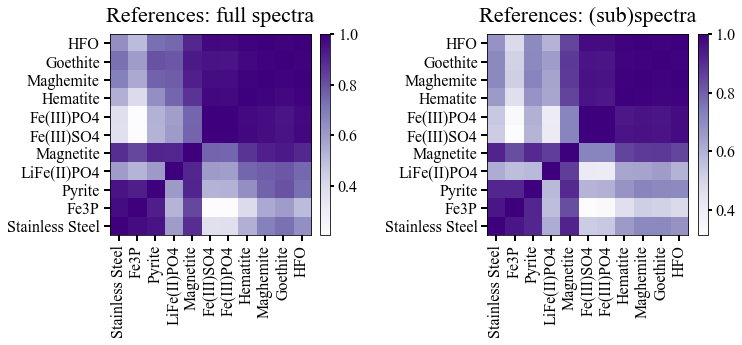

In [33]:
metric = '$R^2$'
fig, axes = plt.subplots(figsize=(11, 3.7), ncols=2)
plt.subplots_adjust(wspace=0.6)

refs = [Refs, Y_Refs]
titles = ['References: full spectra', 'References: (sub)spectra']

for i, ref in enumerate(refs):
    Similarity_matrix = get_similarity_mtx(ref, metric=metric)
    plot_corr_matx(axes[i], Similarity_matrix, data_columns, metric, cmap=plt.cm.Purples)
    axes[i].set_title(titles[i], fontsize=22, y=1.03)

In [45]:
def spacial_clustering(normalized_spectra_dict, Refs, subspectra_dict=None, Y_Refs=None, n_neighbors=25,
                       min_dist=0, dimension=2, threshold=0.97, eps=1., spatial_strength=1,
                       include_spatial_info=True, n_components=30):
    
    normalized_spectra = np.array(list(normalized_spectra_dict.values()))
    pca = PCA(n_components=n_components)
    
    if subspectra_dict is None:
        data = normalized_spectra
    else:
        subspectra = np.array(list(subspectra_dict.values()))
        data = subspectra
    
    pca_components = pca.fit_transform(data)

    n_comp = 0
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n_components)]
    for i, val in enumerate(cdf):
        if val > threshold:
            print(f"It takes {i + 1} PCs to explain {int(threshold * 100)}% variance.")
            n_comp = i + 1
            break

    pca_components = pca_components[:, :n_comp]
    reducer = umap.UMAP(random_state=42, n_components=dimension,
                        n_neighbors=n_neighbors, min_dist=min_dist)

    pts = np.array(list(normalized_spectra_dict.keys()))
    w, h = Fe_xanes.shape[1], Fe_xanes.shape[2]
    joint_space = np.zeros((pca_components.shape[0], pca_components.shape[1] + 2))
    joint_space[:, :pca_components.shape[1]] = pca_components.copy()
    joint_space[:, -2] = pts[:, 0] / w * spatial_strength
    joint_space[:, -1] = pts[:, 1] / h * spatial_strength
    
    if include_spatial_info:
        reduced_space = reducer.fit_transform(joint_space)
    else:
        reduced_space = reducer.fit_transform(pca_components)
        
    clustering = DBSCAN(eps=eps, min_samples=5).fit(reduced_space)

    # true coeffs
    true_contrib_indices = [0, 2, 3, 7]
    targets = normalized_spectra
    basis = Refs[true_contrib_indices]
    expected_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])
    color_labels = [6, 13, 12, 19]
    expected_colors = [plt.cm.tab20(color_labels[c]) for c in np.argmax(expected_coeffs, axis=1)]

    # cluster avgs
    cluster_avgs = [[] for i in np.unique(clustering.labels_)]
    
    for i, s in enumerate(data):
        cluster_avgs[clustering.labels_[i]].append(s)
    for i in np.unique(clustering.labels_):
        cluster_avgs[i] = np.average(cluster_avgs[i], axis=0)
    cluster_avgs = np.array(cluster_avgs)

    # cluster predictions
    if subspectra is not None:
        if Y_Refs is not None:
            basis = Y_Refs
        else:
            print('Ack you need to specify Y_Refs if you specify a subspectra dict')
            return
    else:
        basis = Refs
    cluster_pred_coeffs = get_coeffs_from_spectra(cluster_avgs, basis)
    color_labels = [6, 3, 13, 12, 14, 14, 19, 19, 19, 19]
    
    cluster_colors = [plt.cm.tab20(color_labels[c]) for c in np.argmax(cluster_pred_coeffs, axis=1)] 
    pred_colors = [cluster_colors[clustering.labels_[i]] for i, s in enumerate(normalized_spectra)]
    pred_coeffs = np.array([cluster_pred_coeffs[clustering.labels_[i]] for i, s in enumerate(normalized_spectra)])

    exp_coeffs = np.zeros_like(pred_coeffs)
    for i, idx in enumerate(true_contrib_indices):
        exp_coeffs[:, idx] = expected_coeffs[:, i]
    mse = np.average((pred_coeffs - exp_coeffs)**2, axis=0)
    
    return reduced_space, clustering, pred_colors, expected_colors, pred_coeffs, exp_coeffs, mse, pts

In [46]:
spatial_strengths = [0, 0.1, 0.5, 1, 2, 5, 10, 15, 20, 50]
N_neighbors = [5, 10, 30]
n = len(N_neighbors)

Results = {'reduced_space': [[] for i in range(n)], 'clustering': [[] for i in range(n)],
           'pred_colors': [[] for i in range(n)], 'expected_colors': [[] for i in range(n)],
           'pred_coeffs': [[] for i in range(n)], 'expected_coeffs': [[] for i in range(n)],
           'mse': [[] for i in range(n)], 'pts': [[] for i in range(n)]}

for i, spatial_strength in enumerate(spatial_strengths):
    for j, n_neighbors in enumerate(N_neighbors):
        print(f'S = {spatial_strength}, NN = {n_neighbors}')
        results = spacial_clustering(normalized_spectra_dict, Refs, spatial_strength=spatial_strength,
                                     subspectra_dict=postnormalized_subset_dict,
                                     n_neighbors=n_neighbors, Y_Refs=Y_Refs, n_components=13,
                                     threshold=0.99, include_spatial_info=True)
        for k, key in enumerate(list(Results.keys())):
            Results[key][j].append(results[k])

S = 0, NN = 5
It takes 8 PCs to explain 99% variance.
S = 0, NN = 10
It takes 8 PCs to explain 99% variance.
S = 0, NN = 30
It takes 8 PCs to explain 99% variance.
S = 0.1, NN = 5
It takes 8 PCs to explain 99% variance.
S = 0.1, NN = 10
It takes 8 PCs to explain 99% variance.
S = 0.1, NN = 30
It takes 8 PCs to explain 99% variance.
S = 0.5, NN = 5
It takes 8 PCs to explain 99% variance.
S = 0.5, NN = 10
It takes 8 PCs to explain 99% variance.
S = 0.5, NN = 30
It takes 8 PCs to explain 99% variance.
S = 1, NN = 5
It takes 8 PCs to explain 99% variance.
S = 1, NN = 10
It takes 8 PCs to explain 99% variance.
S = 1, NN = 30
It takes 8 PCs to explain 99% variance.
S = 2, NN = 5
It takes 8 PCs to explain 99% variance.
S = 2, NN = 10
It takes 8 PCs to explain 99% variance.
S = 2, NN = 30
It takes 8 PCs to explain 99% variance.
S = 5, NN = 5
It takes 8 PCs to explain 99% variance.
S = 5, NN = 10
It takes 8 PCs to explain 99% variance.
S = 5, NN = 30
It takes 8 PCs to explain 99% variance.
S = 

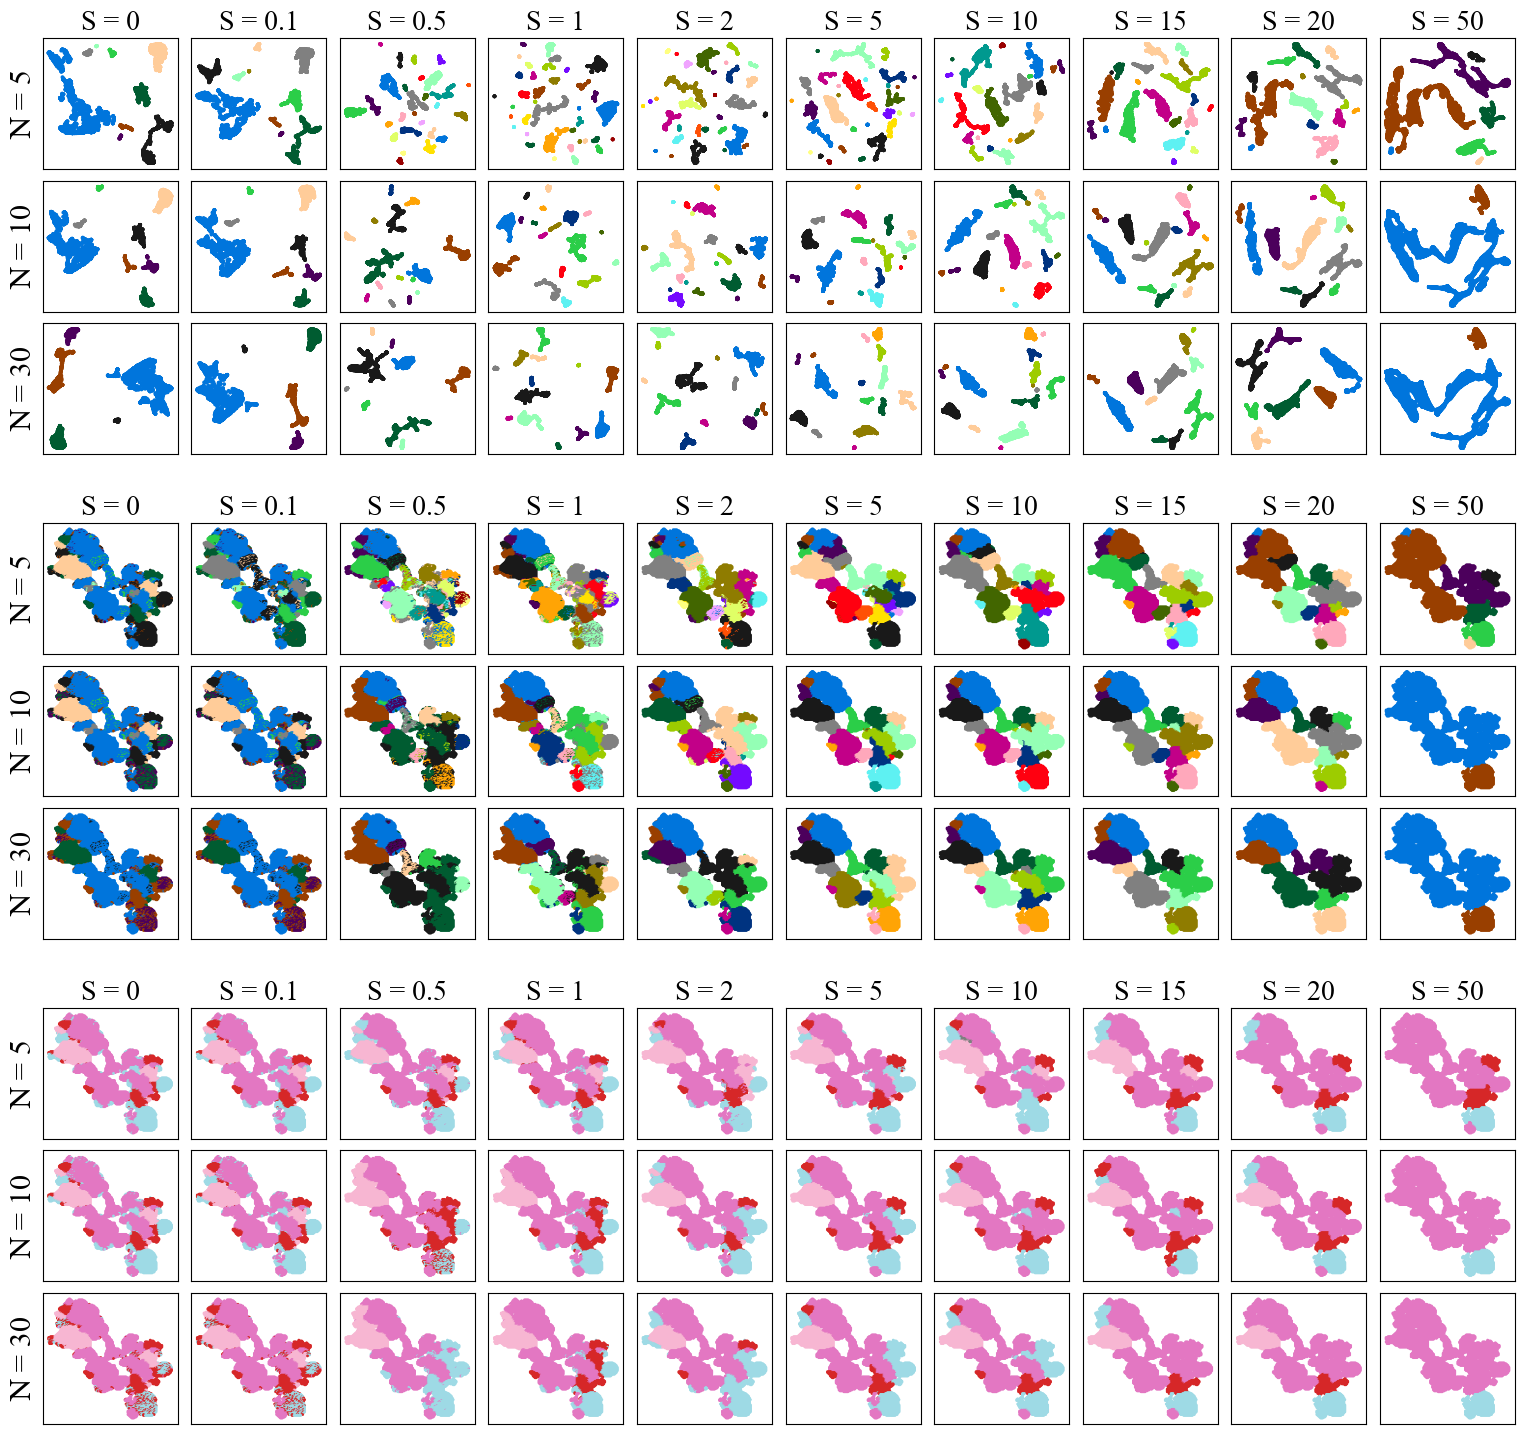

In [47]:
nrows = len(N_neighbors)
ncols = len(spatial_strengths)
fig = plt.figure(figsize=(1.9 * ncols, 2 * nrows * 3))
spec = fig.add_gridspec(ncols=ncols, nrows=nrows * 3 + 2,
                        height_ratios=[1, 1, 1, 0.35, 1, 1, 1, 0.35, 1, 1, 1])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
axes = [[fig.add_subplot(spec[i, j]) for j in range(ncols)]
        for i in range(nrows * 3 + 2)]

for i, j in itertools.product(range(nrows), range(ncols)):
    colors = [discrete_cmap[(c + 1) % 26] for c in Results['clustering'][i][j].labels_]
    pts = Results['pts'][0][0]
    axes[i][j].scatter(Results['reduced_space'][i][j][:, 0], Results['reduced_space'][i][j][:, 1],
                       c=colors, s=3)
    axes[i + 4][j].scatter(pts[:, 1], -pts[:, 0], c=colors, s=1)
    axes[i + 8][j].scatter(pts[:, 1], -pts[:, 0], c=Results['pred_colors'][i][j], s=1)
    
    if i == 0:
        for ax in [axes[i + 3][j], axes[i + 7][j]]:
            ax.axis('off')
    
    for ax in [axes[i][j], axes[i + 4][j], axes[i + 8][j]]:
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(f'S = {spatial_strengths[j]}', fontsize=20)
        if j == 0:
            ax.set_ylabel(f'N = {N_neighbors[i]}', fontsize=22)

# Supplementary figures and analysis

### Visualize normalization parameters

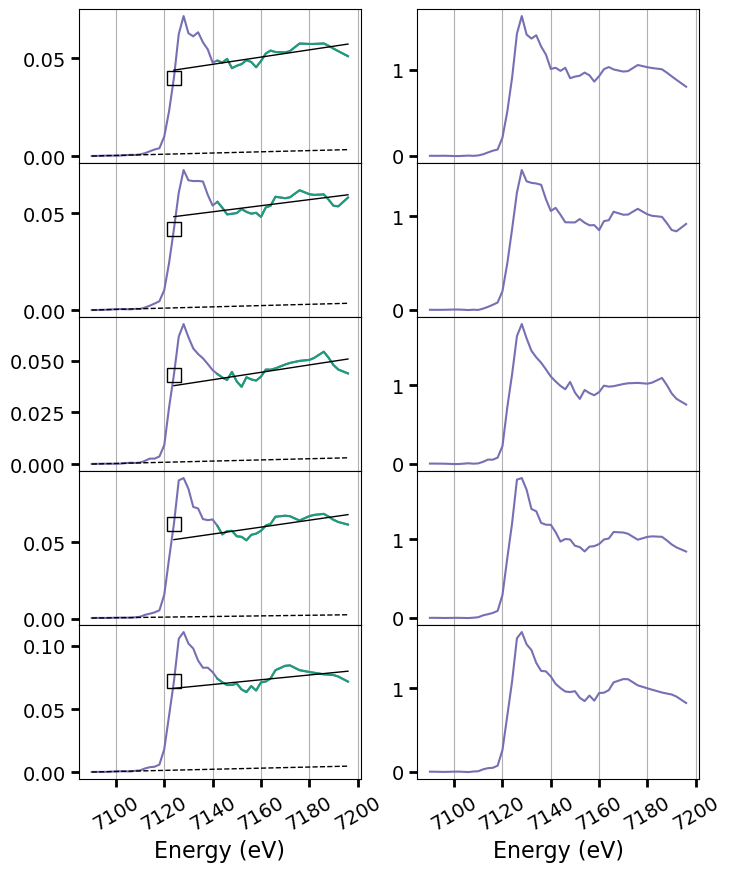

In [31]:
show_normalization(energy, filtered_spectra, N=5, pre_edge_offset=10, 
                   post_edge_offset=-28, whiteline_range=-1, 
                   colors=[plt.cm.Dark2(i) for i in [2, 0]])

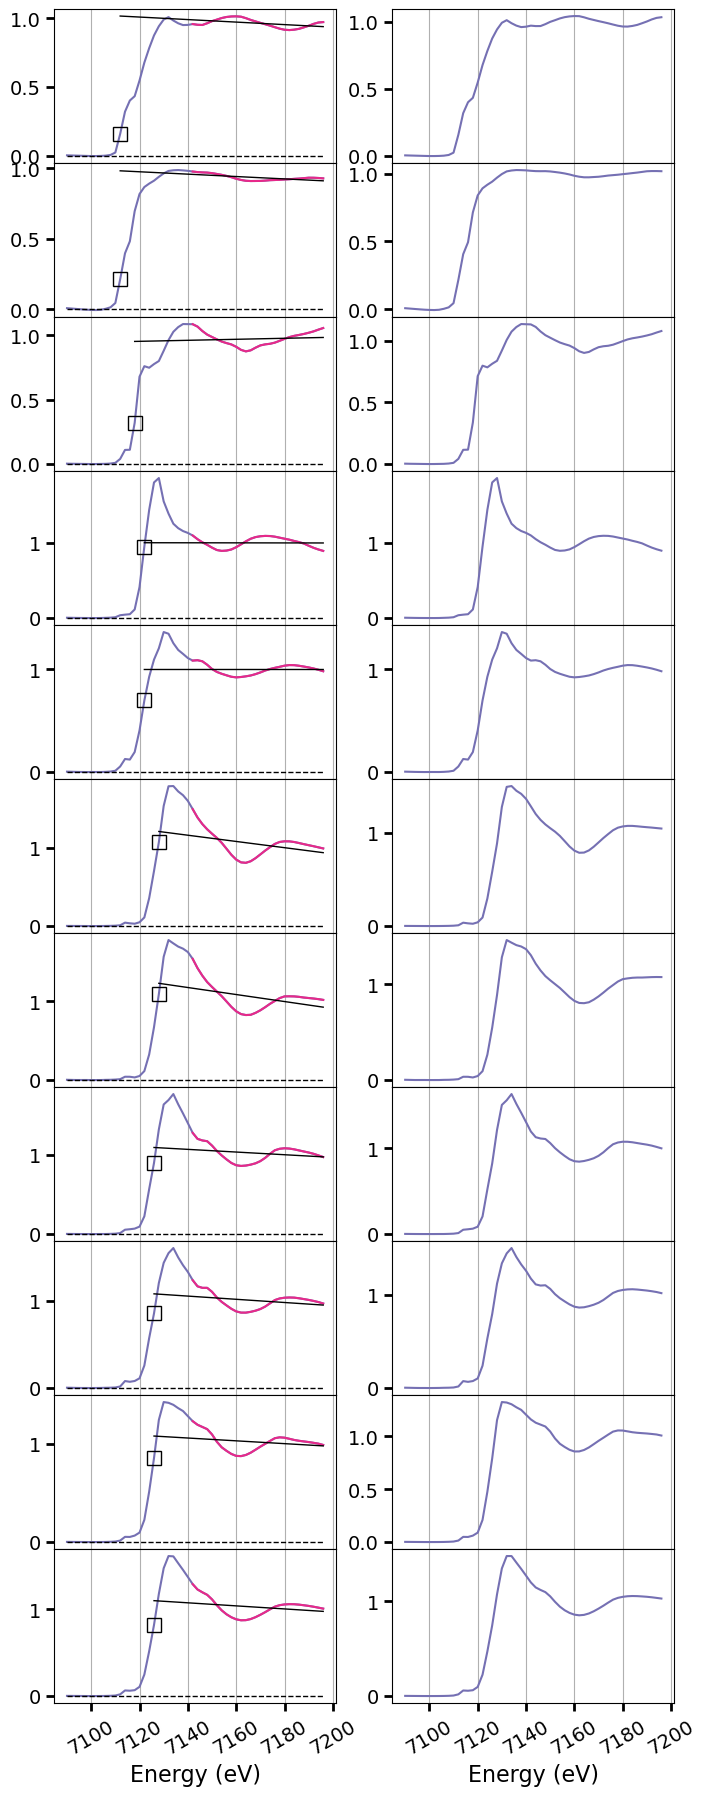

In [32]:
show_normalization(energy, Refs, N=11, return_params=True,pre_edge_offset=10, 
                   post_edge_offset=-28, whiteline_range=-1, colors=[plt.cm.Dark2(i) for i in [2, 3]])

### Time calculations using the standard pixel-by-pixel LCF with stepwise regression

In [23]:
targets = normalized_spectra
start = timeit.default_timer()

for l in range(1, 5):
    combos = np.array(list(itertools.combinations(Refs, l)))
    print(combos.shape)
    for basis in combos:
        coeffs = np.array([list(np.linalg.lstsq(basis.T, target)[0]) for target in targets])

stop = timeit.default_timer()
runtime = time.strftime('%H:%M:%S', time.gmtime(stop - start))
print(f"Runtime: {runtime}")

(11, 1, 54)


C:\Users\saman\AppData\Local\Temp\ipykernel_10700\2454524811.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs = np.array([list(np.linalg.lstsq(basis.T, target)[0]) for target in targets])


(55, 2, 54)
(165, 3, 54)
(330, 4, 54)
Runtime: 00:04:08


### Time calculations using MPIS (with UMAP + dbscan)

In [26]:
start = timeit.default_timer()

reduced_space = get_reduced_space(normalized_spectra, normalized_spectra_dict, method='UMAP', n_neighbors=20)   
clusterizer = DBSCAN(eps=1, min_samples=1).fit(reduced_space)

stop = timeit.default_timer()
runtime = time.strftime('%H:%M:%S', time.gmtime(stop - start))
print(f"Runtime: {runtime}")

Runtime: 00:00:36


### Make correlation matrices using different metrics

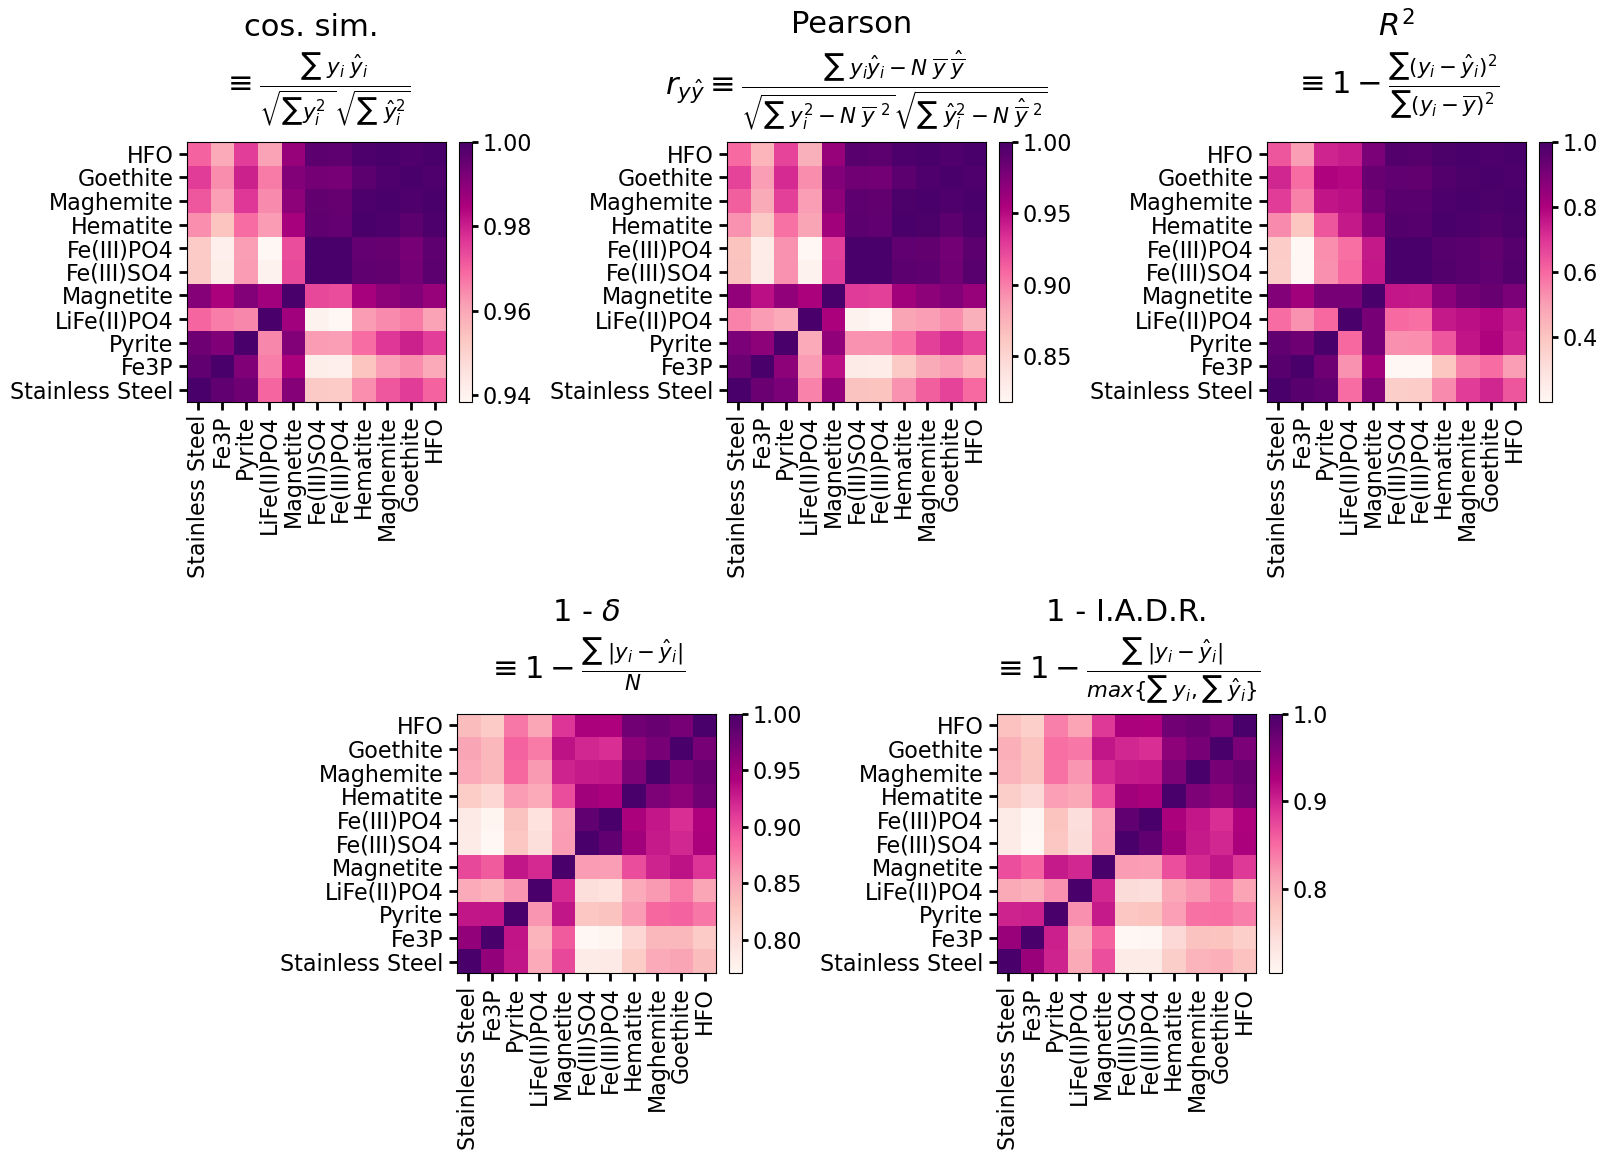

In [21]:
metrics = ['cosine similarity', 'Pearson correlation', '$R^2$', '1 - $\delta$', '1 - IADR']

fig = plt.figure(figsize=(3 * 6, 5.4 * 2))
spec = fig.add_gridspec(ncols=6, nrows=2)
plt.subplots_adjust(wspace=5., hspace=1.2)
plots = [spec[0, :2], spec[0, 2:4], spec[0, 4:], spec[1, 1:3], spec[1, 3:5]]
axes = [fig.add_subplot(plot) for plot in plots]

for i, metric in enumerate(metrics):
    Similarity_matrix = get_similarity_mtx(Refs, metric=metric)
    plot_corr_matx(axes[i], Similarity_matrix, data_columns, metric)
    if i in [3, 4]:
        y = 1.1
    else:
        y = 1.15
    axes[i].set_title(axes[i].get_title(), fontsize=22, y=y)
    
plt.savefig('Figures/similarity_matrices.png', dpi=400, transparent=False, bbox_inches='tight')

### Visualize references with respect to experimental data

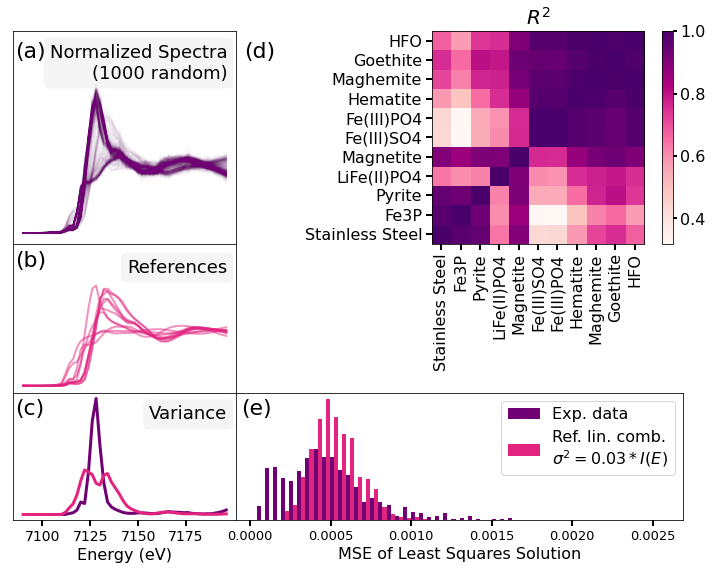

In [41]:
fig = plt.figure(figsize=(12, 9))
spec = fig.add_gridspec(nrows=3, ncols=2,
                        height_ratios=[1, 0.7, 0.6], width_ratios=[0.5, 1])
plt.subplots_adjust(hspace=0., wspace=0.)
axes = []
for i in range(3):
    tmp = [fig.add_subplot(spec[i, j]) for j in range(2)]
    axes.append(tmp)
    
colors = [plt.cm.RdPu(0.9), plt.cm.PuRd(0.65)]
w = (.95, .95, .95, 0.7)
white_bbox = dict(boxstyle="round", ec=w, fc=w)

c = 0
N = 1000
tmp_X = []
for i in range(len(filtered_spectra)):
    mod = 2
    x = normalized_spectra[mod * i]
    tmp_X.append(x)
    axes[0][0].plot(energy, normalized_spectra[mod * i], linewidth=1.5, alpha=0.01,
                    color=colors[0])
    c += 1
    if c > N:
        tmp_X = np.array(tmp_X)
        axes[0][0].plot(energy[0], [2.8], '.', c='w', alpha=0)
        break

axes[2][0].plot(energy, np.var(tmp_X, axis=0), linewidth=3, c=colors[0])

for i, r in enumerate(Refs):
    axes[1][0].plot(energy, r, linewidth=2, alpha=0.5, color=colors[1])
axes[1][0].plot(energy[0], [2.5], '.', c='w', alpha=0)

axes[2][0].plot(energy, np.var(Refs, axis=0), linewidth=3, c=colors[1])

labels = [f'Normalized Spectra\n({N} random)', 'References', 'Variance']

panels = ['(a)', '(b)', '(c)', '(d)', '(e)']
for i, ax_list in enumerate(axes):
    for j, ax in enumerate(ax_list):
        if j == 0:
            if i == 0:
                y = 0.94
                ax.text(0.96, y, labels[i], transform=ax.transAxes, fontsize=18, va='top', ha='right',
                        bbox=white_bbox)
            else:
                y = 0.9
                ax.text(0.96, y, labels[i], transform=ax.transAxes, fontsize=18, va='top', ha='right',
                        bbox=white_bbox)
            ax.tick_params(direction='out', width=2, length=6, labelsize=14)
            ax.set_yticks([])
            if i != 2:
                ax.set_xticks([])
            else:
                ax.set_xticks([7100, 7125, 7150, 7175])
                ax.set_xlabel('Energy (eV)', fontsize=16)
            
            ax.text(0.01, 0.95, panels[i], transform=ax.transAxes, 
                    fontsize=22, va='top', ha='left')
        
        elif (i, j)  == (0, 1):
            ax.text(-0.88, 0.95, panels[3], transform=ax.transAxes, 
                    fontsize=22, va='top', ha='left')
        elif (i, j)  == (2, 1):
            ax.text(0.01, 0.95, panels[4], transform=ax.transAxes, 
                    fontsize=22, va='top', ha='left')
metric = '$R^2$'
Similarity_matrix = get_similarity_mtx(Refs, metric=metric)
metric = '$ R^2 $'
plot_corr_matx(axes[0][1], Similarity_matrix, data_columns, metric)

axes[1][1].axis('off')
plot_MSE_hist(axes[2][1], tmp_X, Refs, bins=50, colors=colors, scale=0.03)
plt.savefig('Figures/Data_vs_Refs.png', dpi=600, bbox_inches='tight', transparent=True)

### Scree plot of references

In [ ]:
make_scree_plot(Refs, threshold=.98, show_first_PC=False, c=13)
plt.title('References', fontsize=20)
plt.savefig('Figures/refs_scree.png', dpi=400, bbox_inches='tight')

### Visualize XRF

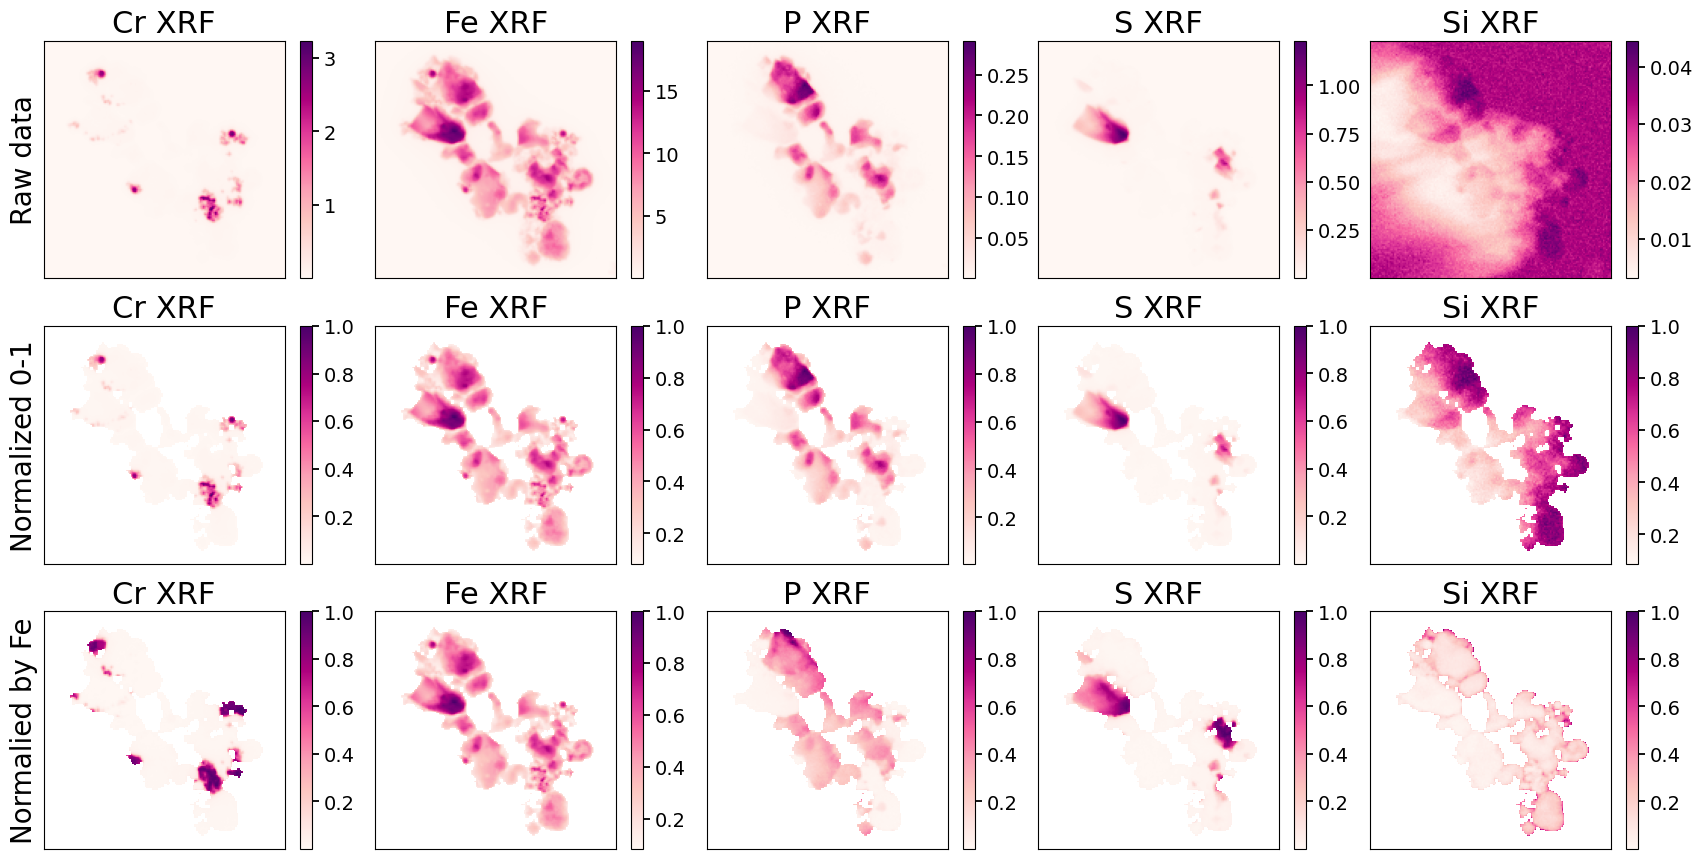

In [25]:
fig, axlist = plt.subplots(figsize=(4.2 * len(elements), 3.5 * 3),
                           ncols=len(elements), nrows=3)
plt.subplots_adjust(wspace=0.1)

global_mask = np.array(mask[0], dtype=bool)
ylabels = ['Raw data', 'Normalized 0-1', 'Normalied by Fe']

for j, axes in enumerate(axlist):   
    for i, ax in enumerate(axes):
        apply_mask = True
        if j == 0:
            norm_xrf = xrfs[elements[i]]
            apply_mask = False
        elif j == 1:
            norm_xrf = xrfs[elements[i]]
            norm_xrf = norm_xrf - np.min(norm_xrf)
            norm_xrf = norm_xrf / np.max(norm_xrf)
        else:
            if i != 1:
                norm_xrf = xrfs[elements[i]] / xrfs[elements[1]]
            else:
                norm_xrf = xrfs[elements[i]]
            norm_xrf = norm_xrf - np.min(norm_xrf)
            norm_xrf = norm_xrf / np.max(norm_xrf) 

        if apply_mask:
            masked_img = np.ma.masked_array(norm_xrf, mask=global_mask)
            masked_img = masked_img / np.max(masked_img)
            img = ax.imshow(masked_img, extent=[0, 1, 0, 1], aspect='auto', cmap=plt.cm.RdPu)
        else:
            img = ax.imshow(norm_xrf, extent=[0, 1, 0, 1], aspect='auto', cmap=plt.cm.RdPu)
        
        if i == 0:
            ax.set_ylabel(ylabels[j], fontsize=20)
        
        remove_ticks(ax)
        ax.set_title(f'{elements[i]} XRF', fontsize=22)
        cbar = plt.colorbar(img, ax=ax)
        if j > 0:
            cbar.ax.set_yticks(np.arange(0.2, 1.2, 0.2))
        cbar.ax.tick_params(width=1.3, length=5, labelsize=14)

## Map references onto UMAP space using experimental data

In [11]:
normalized_spectra = np.array(list(normalized_spectra_dict.values()))
pca = PCA(n_components=30)
pca_components = pca.fit_transform(normalized_spectra)

threshold = 0.97
n_components = 0
cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(30)]
for i, val in enumerate(cdf):
    if val > threshold:
        print(f"It takes {i + 1} PCs to explain {int(threshold * 100)}% variance.")
        n_components = i + 1
        break
print(f'n components = {n_components}')
pca = PCA(n_components=n_components)
pca_components = pca.fit_transform(normalized_spectra)

dimension = 2
n_neighbors = 35 #10
min_dist = 0
dimension = 2
reducer = umap.UMAP(random_state=42, n_components=dimension,
                    n_neighbors=n_neighbors, min_dist=min_dist)
reduced_space = reducer.fit_transform(pca_components)

eps = 1
clustering = DBSCAN(eps=eps, min_samples=5).fit(reduced_space)

ref_space = reducer.transform(pca.transform(Refs))

pts = np.array(list(normalized_spectra_dict.keys()))

# cluster avgs
cluster_avgs = [[] for i in np.unique(clustering.labels_)]
for i, s in enumerate(normalized_spectra):
    cluster_avgs[clustering.labels_[i]].append(s)
for i in np.unique(clustering.labels_):
    cluster_avgs[i] = np.average(cluster_avgs[i], axis=0)
cluster_avgs = np.array(cluster_avgs)

It takes 6 PCs to explain 97% variance.
n components = 6


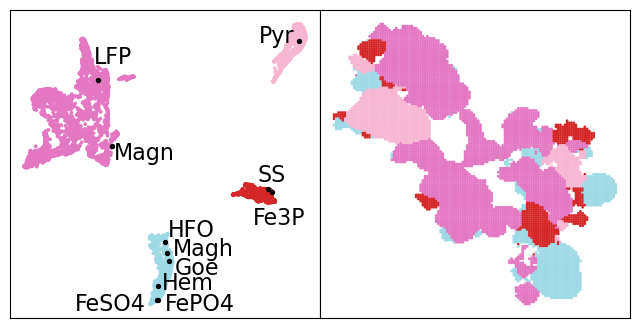

In [51]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(ncols=2)
axes = [fig.add_subplot(spec[j]) for j in range(2)]
plt.subplots_adjust(wspace=0)

color_labels = [12, 19, 6, 13]
colors = [plt.cm.tab20(color_labels[c]) for c in clustering.labels_]

axes[0].scatter(reduced_space[:, 0], reduced_space[:, 1], c=colors, s=3)
axes[0].scatter(ref_space[:, 0], ref_space[:, 1], c='k', s=8)
axes[1].scatter(pts[:, 1], -pts[:, 0], c=colors, s=1)

w = axes[0].get_xlim()[1] - axes[0].get_xlim()[0]
h = axes[0].get_ylim()[1] - axes[0].get_ylim()[0]

for i, label in enumerate(['SS','Fe3P','Pyr','LFP','Magn','FeSO4',
                           'FePO4','Hem','Magh','Goe','HFO']):
    if label == 'Fe3P':
        x = 1
        y = -2.6
    elif label == 'FeSO4':
        x = -4
        y = -1
    elif label == 'FePO4':
        x = 3.5
        y = -1
    elif label in ['Hem','Magh','Goe','HFO']:
        if label == 'Hem':
            y = -0.6
            x = 2.5
        elif label == 'HFO':
            y = 1.2
            x = 1.9
        elif label == 'Goe':
            y = -2.4
            x = 2.7
        elif label == 'Magh':
            x = 3.
            y = -0.5
    elif label =='Magn':
        x = 2.75
        y = -1.2
    elif label == 'LFP':
        x = 1.3
        y = .7
    elif label == 'SS':
        x = 0
        y = 0.3
    elif label == 'Pyr':
        x = -1.9
        y = -.4
    
    axes[0].text(ref_space[i, 0] + x, ref_space[i, 1] + y, label, fontsize=16,
                 ha='center', va='bottom')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig('Figures/Refs_on_experimental_UMAP_space.png', dpi=600, bbox_inches='tight')

### Image processing (testing out spatial information augmentation)

In [43]:
def spacial_clustering(normalized_spectra_dict, Refs, n_neighbors=10, min_dist=0, dimension=2,
                       threshold=0.97, eps=1.5, spatial_strength=1, include_spatial_info=True):
    
    normalized_spectra = np.array(list(normalized_spectra_dict.values()))
    pca = PCA(n_components=30)
    pca_components = pca.fit_transform(normalized_spectra)

    n_components = 0
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(30)]
    for i, val in enumerate(cdf):
        if val > threshold:
            print(f"It takes {i + 1} PCs to explain {int(threshold * 100)}% variance.")
            n_components = i + 1
            break

    pca_components = pca_components[:, :n_components]
    reducer = umap.UMAP(random_state=42, n_components=dimension,
                        n_neighbors=n_neighbors, min_dist=min_dist)

    pts = np.array(list(normalized_spectra_dict.keys()))
    w, h = Fe_xanes.shape[1], Fe_xanes.shape[2]
    joint_space = np.zeros((pca_components.shape[0], pca_components.shape[1] + 2))
    joint_space[:, :pca_components.shape[1]] = pca_components.copy()
    joint_space[:, -2] = pts[:, 0] / w * spatial_strength
    joint_space[:, -1] = pts[:, 1] / h * spatial_strength

    if include_spatial_info:
        reduced_space = reducer.fit_transform(joint_space)
    else:
        reduced_space = reducer.fit_transform(pca_components)
        
    clustering = DBSCAN(eps=eps, min_samples=5).fit(reduced_space)

    # true coeffs
    true_contrib_indices = [0, 2, 3, 7]
    targets = normalized_spectra
    basis = Refs[true_contrib_indices]
    expected_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])
    color_labels = [6, 13, 12, 19]
    expected_colors = [plt.cm.tab20(color_labels[c]) for c in np.argmax(expected_coeffs, axis=1)]

    # cluster avgs
    cluster_avgs = [[] for i in np.unique(clustering.labels_)]
    for i, s in enumerate(normalized_spectra):
        cluster_avgs[clustering.labels_[i]].append(s)
    for i in np.unique(clustering.labels_):
        cluster_avgs[i] = np.average(cluster_avgs[i], axis=0)
    cluster_avgs = np.array(cluster_avgs)

    # cluster predictions
    basis = Refs
    cluster_pred_coeffs = get_coeffs_from_spectra(cluster_avgs, basis)
    color_labels = [6, 3, 13, 12, 14, 14, 19, 19, 19, 19]
    
    cluster_colors = [plt.cm.tab20(color_labels[c]) for c in np.argmax(cluster_pred_coeffs, axis=1)] 
    pred_colors = [cluster_colors[clustering.labels_[i]] for i, s in enumerate(normalized_spectra)]
    pred_coeffs = np.array([cluster_pred_coeffs[clustering.labels_[i]] for i, s in enumerate(normalized_spectra)])

    exp_coeffs = np.zeros_like(pred_coeffs)
    for i, idx in enumerate(true_contrib_indices):
        exp_coeffs[:, idx] = expected_coeffs[:, i]
    mse = np.average((pred_coeffs - exp_coeffs)**2, axis=0)
    
    return reduced_space, clustering, pred_colors, expected_colors, pred_coeffs, exp_coeffs, mse, pts

In [35]:
reduced_space, clustering, pred_colors, = [], [], []
expected_colors, pred_coeffs, expected_coeffs = [], [], []
mse, pts = [], []
Results = {'reduced_space': [], 'clustering': [], 'pred_colors': [],
           'expected_colors': [], 'pred_coeffs': [], 'expected_coeffs': [],
           'mse': [], 'pts': []}

for i in range(2):
    if i == 0:
        include_spatial_info = False
    else:
        include_spatial_info = True
    results = spacial_clustering(normalized_spectra_dict, Refs, include_spatial_info=include_spatial_info)
    for j, key in enumerate(list(Results.keys())):
        Results[key].append(results[j])

It takes 6 PCs to explain 97% variance.
It takes 6 PCs to explain 97% variance.


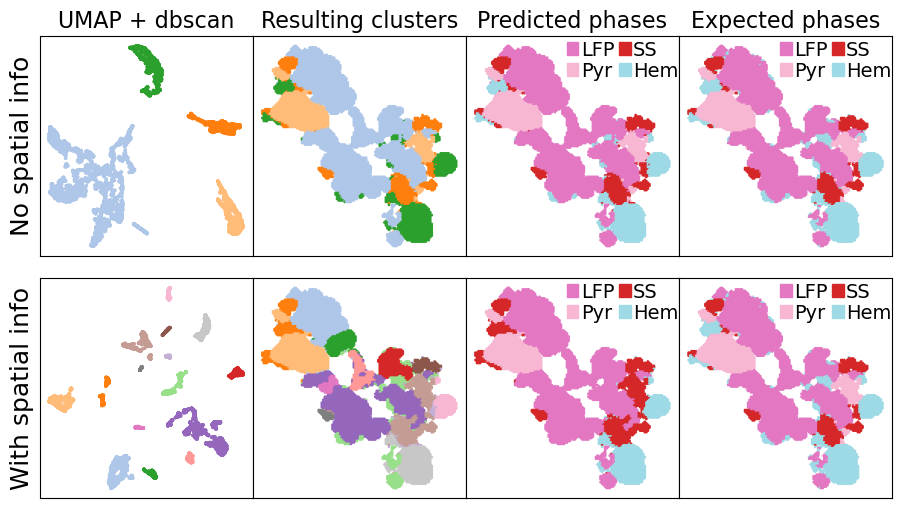

In [36]:
titles = ['UMAP + dbscan', 'Resulting clusters', 'Predicted phases', 'Expected phases']

fig, axes = plt.subplots(figsize=(11, 6), ncols=4, nrows=2)
plt.subplots_adjust(wspace=0., hspace=0.1)
ylabels = ['No spatial info', 'With spatial info']

for i in range(2):
    colors = [plt.cm.tab20(c + 1) for c in Results['clustering'][i].labels_]
    axes[i, 0].scatter(Results['reduced_space'][i][:, 0], Results['reduced_space'][i][:, 1],
                       c=colors, s=3)
    pts = Results['pts'][0]
    axes[i, 1].scatter(pts[:, 1], -pts[:, 0], c=colors, s=1)
    axes[i, 2].scatter(pts[:, 1], -pts[:, 0], c=Results['pred_colors'][i], s=1)
    axes[i, 3].scatter(pts[:, 1], -pts[:, 0], c=Results['expected_colors'][i], s=1)
    axes[i, 0].set_ylabel(ylabels[i], fontsize=18)

for i, axl in enumerate(axes):
    for j, ax in enumerate(axl):
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(titles[j], fontsize=16)
        if j >= 2:
            labels = ['LFP', 'Pyr', 'SS', 'Hem']
            color_labels = [12, 13, 6, 19]
            colors = [plt.cm.tab20(c) for c in color_labels]
            patches = [mpatches.Patch(color=plt.cm.tab20(color_labels[i]),
                       label=labels[i]) for i in range(len(labels))]
            leg = ax.legend(handles=patches, fontsize=14, ncol=2, framealpha=0,
                            handlelength=.6, loc=1, bbox_to_anchor=(1.08, 1.06),
                            labelspacing=.1, handletextpad=0.12, columnspacing=0.25)

### Testing both XRF and spatial location augmentation

Couldn't cluster 0 points
Couldn't cluster 0 points
Couldn't cluster 0 points


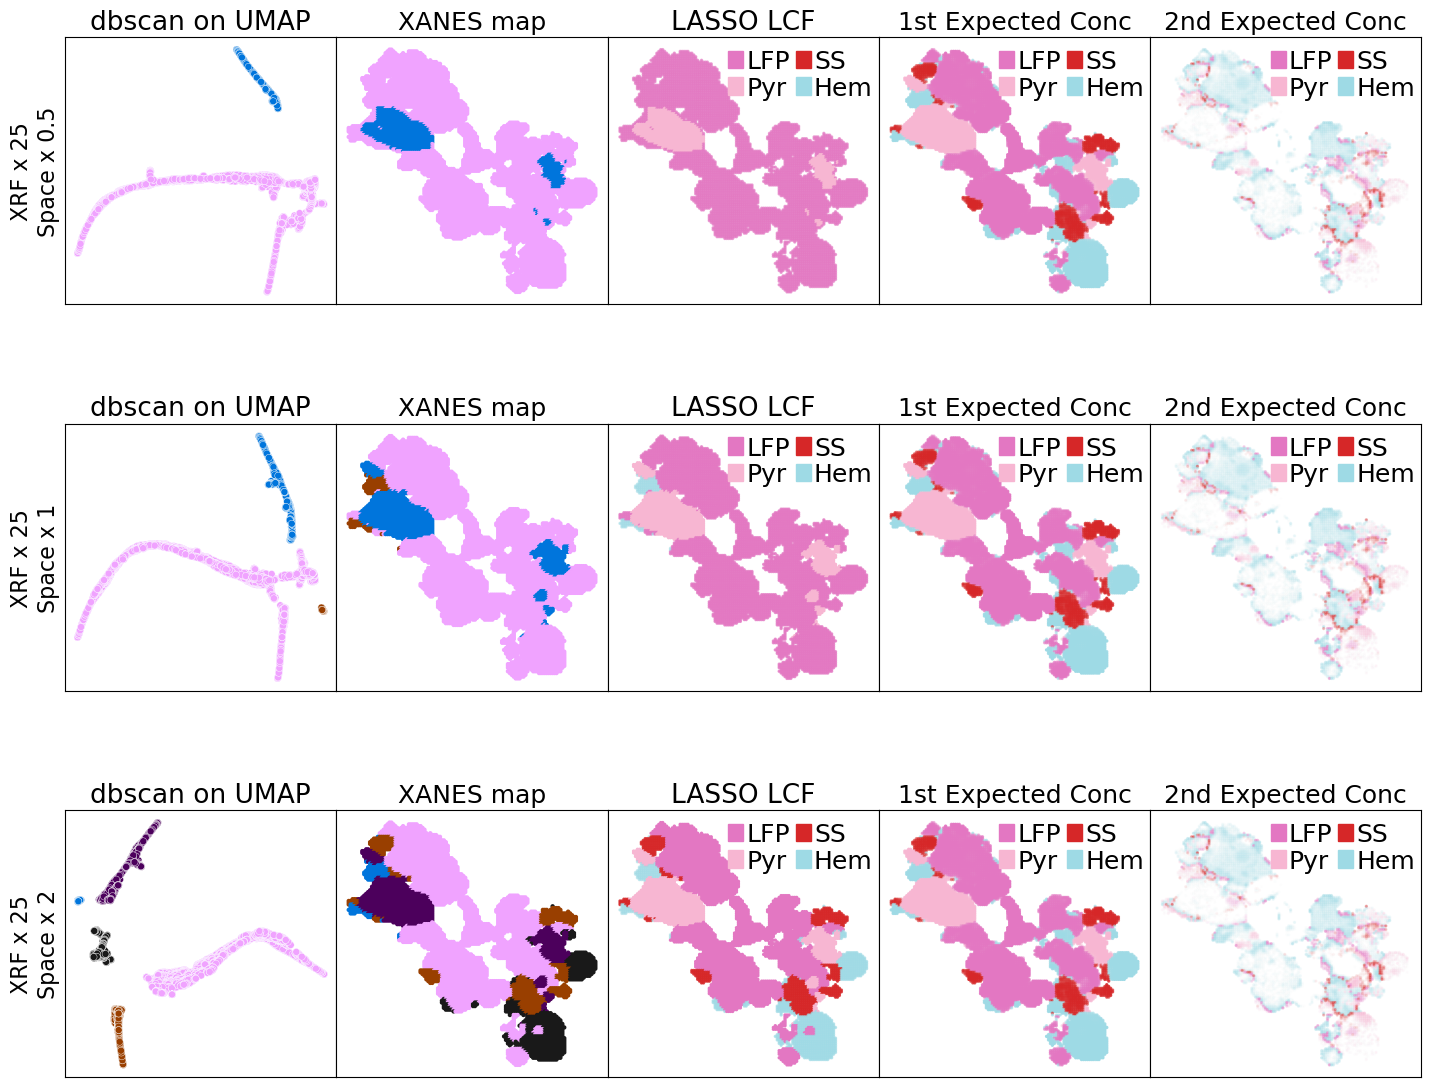

In [37]:
xrf_strengths = [1, 5, 10]
spatial_strengths = [0.5, 1, 2]

nrows = len(xrf_strengths)
ncols = 5
fig, axes = plt.subplots(figsize=(3.5 * ncols, nrows * 4.5), ncols=ncols, nrows=nrows)
plt.subplots_adjust(wspace=0., hspace=0.45)

for i, spatial_strength in enumerate(spatial_strengths):
    xrf_strength = 25
    two_dimensional_clustering((fig, axes[i]), normalized_spectra, normalized_spectra_dict, Refs,
                               method='UMAP', clustering='dbscan', xrf=xrf, xrf_strength=xrf_strength,
                               translation=0, data_description='full_spectra', spatial_strength=spatial_strength)
    axes[i, 0].set_ylabel(f'XRF x {xrf_strength}\nSpace x {spatial_strength}', fontsize=16)

### RFE supplementary figure

In [ ]:
best_estimator = 'Linear Regression'
kwargs = {'N': 1000, 'scale': 0.0, 'dropout': 0.8}

best_ns = [1, 1, 1]
modes = ['Nonlinear->alpha', 'Linear->alpha', 'Linear->beta']

pca = PCA(n_components=5)
transformed_basis = pca.fit_transform(basis)

reps = 10
RFEs = []
Indices = []
X, Y = [], []
for j, mode in enumerate(modes):
    print(mode)
    Is, rfes = [], []
    for i in range(reps):
        print(i, end='\r')
        data, coeffs = generate_linear_combos(basis, **kwargs)        
        transformed_data = pca.transform(data)
        projections = transformed_data @ pca.components_
        if j == 0:
            x, y = data, coeffs
        elif j == 1:
            x, y = projections, coeffs
        else:
            x, y = projections, transformed_data
        
        select = energy_point_selector.Selector(x, y)
        rfe, score = select.select_energy_points(estimator=best_estimator, n_points=best_ns[j],
                                                 verbose=True, scoring='r2')
        rfes.append(rfe)
        energy_measurements = energy[rfe.support_]
        indices = [i for i, e in enumerate(energy) if e in energy_measurements]
        Is.append(indices)
        X.append(x)
        Y.append(Y)
        RFEs.append(rfes)
        Indices.append(Is)

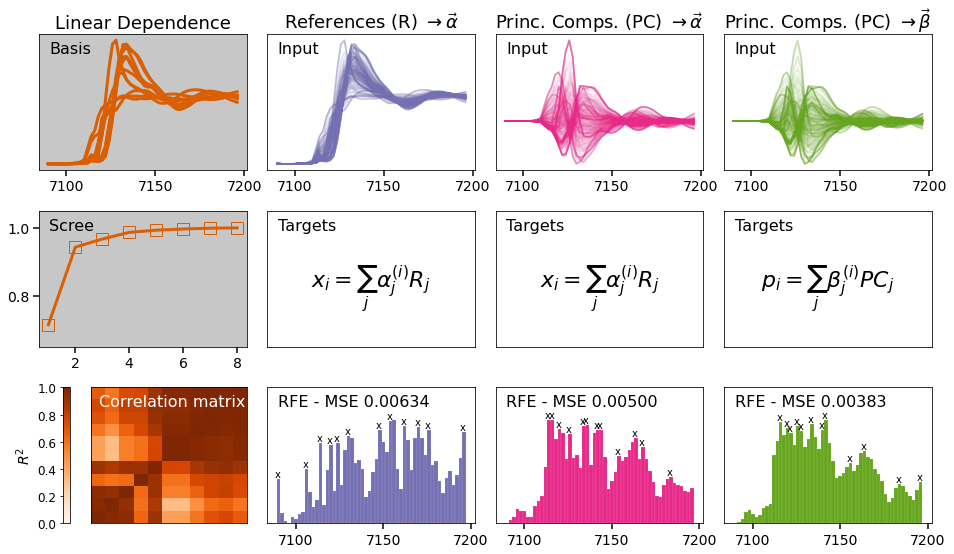

In [61]:
fig, axes = plt.subplots(figsize=(4 * 4, 3 * 3), ncols=4, nrows=3)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
target_labels = [r'$x_i = \sum_j \alpha_j^{(i)}R_j$',
                 r'$x_i = \sum_j \alpha_j^{(i)}R_j$',
                 r'$p_i = \sum_j \beta_j^{(i)}PC_j$']
ax_labels = ['Input', 'Targets', 'RFE']
modes = ['Linear Dependence',
         r'References (R) $ \rightarrow \vec{\alpha}$', 
         r'Princ. Comps. (PC) $ \rightarrow \vec{\alpha}$', 
         r'Princ. Comps. (PC) $ \rightarrow \vec{\beta}$']
Indices = [[ 0,  8, 12, 15, 17, 20, 29, 32, 36, 40, 43, 53], 
           [12, 13, 15, 18, 22, 23, 26, 27, 32, 37, 39, 47], 
           [13, 15, 16, 18, 19, 22, 25, 26, 33, 37, 47, 53]]

kwargs = {'N': 500, 'scale': 0.0, 'dropout': 0.8}
data, true_coeffs = generate_linear_combos(Refs, **kwargs)

for i, dataset in enumerate(X):
    for x in dataset[:500]:
        axes[0, i + 1].plot(energy, x, alpha=0.05, c=plt.cm.Dark2(i + 2))
    axes[1, i + 1].set_ylabel(target_labels[i], fontsize=22, rotation=0)
    axes[1, i + 1].yaxis.set_label_coords(0.5, 0.25)
        
    res = energy[1] - energy[0]
    ranks = 54 * reps - np.sum(np.array([rfe.ranking_ for rfe in RFEs[i]], dtype=float), axis=0)
    axes[2, i + 1].bar(energy, ranks, width=res,
                       ec='w', linewidth=0.1, color=plt.cm.Dark2(i + 2))
    axes[2, i + 1].set_ylim(0, axes[2, i + 1].get_ylim()[1] * 1.25)
    for idx in Indices[i]:
        axes[2, i + 1].text(energy[idx] + res / 2, ranks[idx], 'x', 
                            ha='right', va='bottom', fontsize=10)
    
    sliced_data = np.array([data[:, idx] for idx in Indices[i]])
    sliced_basis = np.array([Refs[:, idx] for idx in Indices[i]])
    pred_coeffs = get_coeffs_from_spectra(sliced_data.T, sliced_basis.T)
    score = mean_squared_error(true_coeffs, pred_coeffs)
    
    for j, ax in enumerate(axes[:, i + 1]):
        if j == 1:
            ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(length=6, width=1.5, labelsize=14)
        if j == 2:
            text = f'{ax_labels[j]} - MSE {score:.5f}'
        else:
            text = ax_labels[j]
        ax.text(0.05, 0.95, text, transform=ax.transAxes, 
                ha='left', va='top', fontsize=16)
    

first_column_labels = ['Basis', 'Scree', 'Correlation matrix']

# plot basis
for b in basis:
    axes[0, 0].plot(energy, b, c=plt.cm.Dark2(1), linewidth=3)

# plot scree
pca = PCA()
pca_components = pca.fit_transform(basis)
x = np.arange(8) + 1
cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(8)]
axes[1, 0].plot(x, cdf, 's-', markersize=12, fillstyle='none', 
                color=plt.cm.Dark2(1), linewidth=3)
axes[1, 0].set_ylim(axes[1, 0].get_ylim()[0] - 0.05, 1.05)

# plot corr mtx
Similarity_matrix = get_similarity_mtx(basis, metric='$R^2$')
img = axes[2, 0].imshow(Similarity_matrix, cmap=plt.cm.Oranges,
                        interpolation='nearest', origin='lower',
                        vmin=0, vmax=1, aspect='auto')
cbar = plt.colorbar(img, ax=axes[2, 0], location='left')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('$R^2$', fontsize=14)

for j, ax in enumerate(axes[:, 0]):
    if j != 1:
        ax.set_yticks([])
    ax.tick_params(length=6, width=1.5, labelsize=14)
    ax.set_facecolor(plt.cm.tab20(15))
    if j == 2:
        ax.set_xticks([])
        c = 'w'
    else:
        c = 'k'
    ax.text(0.05, 0.95, first_column_labels[j], transform=ax.transAxes, 
            ha='left', va='top', fontsize=16, c=c)
    
for i, mode in enumerate(modes):
    axes[0, i].set_title(mode, fontsize=18)